# Classificação de Comentários Tóxicos

Este notebook foi desenvolvido com o objetivo de treinar um modelo de machine learning capaz de realizar a tarefa de classificação de textos. O objetivo final deste modelo será a identificação de textos com conteúdo nocivo. Os dados utilizados para treinamento do modelo foram extraídos da plataforma kaggle no seguinte link:
https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge

# Importação de Bibliotecas

O primeiro passo do nosso projeto será a importação de bibliotecas. Na célula abaixo fazemos a importação de todos os pacotes que serão necessários para rodarmos este notebook.

In [1]:
# Bibliotecas para manipulação de dados
import pandas as pd
import numpy as np

# Bibliotecas para visualização de dados
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

# Biblioteca para manipulação de textos
import nltk

# Bibliotecas nativas do python
import os
import re
import string
import json
import pickle
from collections import Counter

# Biblioteca para divisão de conjuntos de dados desbalanceados
from skmultilearn.model_selection import iterative_train_test_split, IterativeStratification

# Bibliotecas para treinamento e avaliação de modelos
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# Biblioteca para interface entre redes neurais desenvolvidas no keras e as funções do sklearn
from scikeras.wrappers import KerasClassifier, BaseWrapper

# Bibliotecas para desenvolvimento de redes neurais
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, TextVectorization, Conv1D, MaxPool1D, Embedding, Flatten, Bidirectional, LSTM, concatenate
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.metrics import AUC, FalseNegatives, FalsePositives, TruePositives, TrueNegatives, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, TensorBoard
import keras_tuner as kt

In [2]:
# Configurações para evitar erros do tipo OOM
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Funções

A seguir vamos definir uma série de funções que serão utilizadas no desenvolvimento deste trabalho. A medida que as funções forem sendo aplicadas iremos descrever a utilidade das mesmas.

In [3]:
# Divide o conjunto de dados em conjuntos de treino e teste e retorna dois data frames (treino e test) com os dados X e y concatenados

def train_test_split(df, test_size, random_state = 0):
    
    '''Divide um data frame em conjunto de treino e teste. Esta função é própria para divisão de dados deslanceados.
    
    Parametros:
    df (pandas.DataFrame): Dados que serão divididos.
    test_size (float): Tamanho do conjunto de teste/validação.
    random_state (int): Seed para controlar aleatoreidade na divisão dos dados.
    
    Retorna:
    df_train (pandas.DataFrame): Data Frame com os dados de terino.
    df_test (pandas.DataFrame): Data Frame com os dados de teste.
    
    '''
        
    df = df.sample(frac = 1, random_state = random_state)
    
    np.random.seed(random_state)
    Xtrain, ytrain, Xtest, ytest = iterative_train_test_split(df.iloc[:,0:2].values, df.iloc[:,2:].values, test_size = test_size)
    
    df_train = pd.DataFrame(np.concatenate([Xtrain, ytrain], axis = 1), columns = df.columns)
    df_test = pd.DataFrame(np.concatenate([Xtest, ytest], axis = 1), columns = df.columns)
    
    for i in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
        df_train[i] = df_train[i].astype('int64')
        df_test[i] = df_test[i].astype('int64')
    
    return df_train, df_test

In [4]:
# A função abaixo exibe comentários aleatórios do banco de dados de acordo com o tipo de categoria desejada

def show_reviews(df, categories = 'all'):
    
    '''Exibe comentários aleatórios do banco de dados.
    
    Parametros:
    df (pandas.DataFrame): Data Frame com os dados.
    categories (string, list): Tipo do comentário que será exibido. 
    
    Retorna:
    None
    
    '''
    df = df.apply(int_to_bool,axis = 0)
    
    if categories == 'all':
        mask = (df['toxic'] | df['severe_toxic'] | df['obscene'] | df['threat'] | df['insult'] | df['identity_hate'])
    else:
        mask = np.zeros(df.shape[0], dtype = bool)
        for categorie in categories:
            mask = mask | df[categorie]
    
    review = df.loc[mask,'comment_text'].sample(1).values[0]  
    
    categories = df.loc[mask,['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sample(1).astype(int)
    
    print(review, end = '\n\n')
    print(categories)
    
    return None

In [5]:
# Exibe os 20 termos mais comuns para cada uma das categorias

def show_most_frequent_words(clean_df, categories = 'all', n_words = 5):
    
    '''Exibe os termos mais comuns nas categorias de comentários.
    
    Parametros:
    clean_df (pandas.DataFrame): Data Frame contendo os dados.
    categories (string, list): Nomes das categorias de comentários que serão exibidos.
    n_words (int): Número de palavras que serão exibidas.
    
    Retorna:
    None
    
    '''
    
    
    clean_df = clean_df.apply(int_to_bool,axis = 0)
    
    if categories == 'all':
        mask = (clean_df['toxic']| clean_df['severe_toxic'] | clean_df['obscene'] | clean_df['threat'] | clean_df['insult'] | clean_df['identity_hate'])
    else:
        mask = np.zeros(clean_df.shape[0], dtype = bool)
        for categorie in categories:
            mask = mask | clean_df[categorie]
    
    counter = Counter()
    
    for list_of_tokens in clean_df.loc[mask, 'comment_text']:
        
        counter.update(list_of_tokens)
        
    print(counter.most_common(n_words))
    
    return None

In [6]:
# Converte uma series de int64 para bool

def int_to_bool(column):
    
    '''Converte dados do tipo int64 para bool
    
    parametros:
    column (pandas.Series): Coluna do Data Frame que será modificada.
    
    Retorna:
    column (pandas.Series): Series com dados do tipo bool
        
    '''
    
    if column.dtype == 'int64':
        column = column.astype('bool')
        
    return column

In [7]:
# Limpa o texto e retorna uma list com os tokens extraídos

def clean_text(text):
    
    '''Limpa arquivos de texto e retorna uma lista com os tokens extraídos. São aplicadas as seguintes limpezas:
    1. Divisão do texto em espaços em branco.
    2. Remoção de pontuação.
    3. Remoção de tokens que não são alfanuméricos.
    4. Remoção de stop words.
    5. Remoção de tokens com apenas um caracter.
    6. Remoção de tokens com mais de 15 caracteres.
    7. Remoção de tokens que não são ASC II.
    
    Parametros:
    text (string): String contendo o texto a ser limpo.
    
    Retorna:
    tokens (list): Lista com os tokens extraídos na limpeza de texto.
    
    '''
    
    tokens = text.split()
    
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    
    tokens = [word for word in tokens if word.isalpha()]
    
    tokens = [word.lower() for word in tokens]
    
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    
    tokens = [word for word in tokens if len(word) > 1]
    
    tokens = [word for word in tokens if len(word) < 15]
    
    tokens = [word for word in tokens if word.isascii()]  
    
    return tokens

In [8]:
# Limpa o texto e retorna uma list com os tokens extraídos

def clean_text_2(text):
    
    '''Limpa arquivos de texto e retorna uma lista com os tokens extraídos. São aplicadas as seguintes limpezas:
    1. Divisão do texto em espaços em branco.
    3. Remoção de tokens que não são alfanuméricos.
    7. Remoção de tokens que não são ASC II.
    
    Parametros:
    text (string): String contendo o texto a ser limpo.
    
    Retorna:
    tokens (list): Lista com os tokens extraídos na limpeza de texto.
    
    '''
    
    tokens = text.split()
    
    tokens = [word for word in tokens if word.isalpha()]
    
    tokens = [word for word in tokens if word.isascii()]  
       
    return tokens

Para as expressões em regex utilizadas verificar a referência:
https://github.com/zake7749/DeepToxic/blob/master/clean_data.ipynb

In [9]:
# Limpa o texto e retorna uma list com os tokens extraídos

def clean_text_3(text):
    
    '''Limpa arquivos de texto e retorna uma lista com os tokens extraídos. São aplicadas as seguintes limpezas:
    
    1. Remoção de pontuação, numeração e strings web.
    2. Remoção da indicação de imagens.
    3. Remoção de strings de css.
    4. Remoção de templates.
    5. Correção de palavras.
    6. Divisão do texto em espaços em branco.
    7. Remoção de tokens que não são alfanuméricos.
    9. Remoção de tokens com apenas um caracter.
    10. Remoção de tokens com mais de 15 caracteres.
    11. Remoção de tokens que não são ASC II.
       
    Parametros:
    text (string): String contendo o texto a ser limpo.

    Retorna:
    tokens (list): Lista com os tokens extraídos na limpeza de texto.

    '''
            
    text = text.lower()
        
    text = re.sub(r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)", "", text)
    text = re.sub(r"(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)){3}", "", text)

    # WIKI TOKENS
    text = re.sub(r"image:[a-zA-Z0-9]*\.jpg", " ", text)
    text = re.sub(r"image:[a-zA-Z0-9]*\.png", " ", text)
    text = re.sub(r"image:[a-zA-Z0-9]*\.gif", " ", text)
    text = re.sub(r"image:[a-zA-Z0-9]*\.bmp", " ", text)
    # Drop css
    text = re.sub(r"#([A-Fa-f0-9]{6}|[A-Fa-f0-9]{3})", " ",text)
    text = re.sub(r"\{\|[^\}]*\|\}", " ", text)
    # Clean templates
    text = re.sub(r"\[?\[user:.*\]", " ", text)
    text = re.sub(r"\[?\[user:.*\|", " ", text)        
    text = re.sub(r"\[?\[wikipedia:.*\]", " ", text)
    text = re.sub(r"\[?\[wikipedia:.*\|", " ", text)
    text = re.sub(r"\[?\[special:.*\]", " ", text)
    text = re.sub(r"\[?\[special:.*\|", " ", text)
    text = re.sub(r"\[?\[category:.*\]", " ", text)
    text = re.sub(r"\[?\[category:.*\|", " ", text)
        
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\?", " ? ", text)
    text = re.sub(r"\!", " ! ", text)
    text = re.sub(r"\"", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    tokens = text.split()
            
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    
    tokens = [word for word in tokens if word.isalpha()]
        
    tokens = [word for word in tokens if len(word) > 1]
    
    tokens = [word for word in tokens if len(word) < 15]
    
    tokens = [word for word in tokens if word.isascii()]
        
    return tokens

In [10]:
# Limpa o texto e retorna uma list com os tokens extraídos

def clean_text_4(text, lematizer):
    
    '''Limpa arquivos de texto e retorna uma lista com os tokens extraídos. São aplicadas as seguintes limpezas:
    
    1. Remoção de pontuação, numeração e strings web.
    2. Remoção da indicação de imagens.
    3. Remoção de strings de css.
    4. Remoção de templates.
    5. Correção de palavras.
    6. Divisão do texto em espaços em branco.
    7. Remoção de tokens que não são alfanuméricos.
    9. Remoção de tokens com apenas um caracter.
    10. Remoção de tokens com mais de 15 caracteres.
    11. Remoção de tokens que não são ASC II.
    12. Realiza lemmatização das palavras.
       
    Parametros:
    text (string): String contendo o texto a ser limpo.

    Retorna:
    tokens (list): Lista com os tokens extraídos na limpeza de texto.

    '''
        
    text = text.lower()
        
    text = re.sub(r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)", "", text)
    text = re.sub(r"(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)){3}", "", text)

    # WIKI TOKENS
    text = re.sub(r"image:[a-zA-Z0-9]*\.jpg", " ", text)
    text = re.sub(r"image:[a-zA-Z0-9]*\.png", " ", text)
    text = re.sub(r"image:[a-zA-Z0-9]*\.gif", " ", text)
    text = re.sub(r"image:[a-zA-Z0-9]*\.bmp", " ", text)
    # Drop css
    text = re.sub(r"#([A-Fa-f0-9]{6}|[A-Fa-f0-9]{3})", " ",text)
    text = re.sub(r"\{\|[^\}]*\|\}", " ", text)
    # Clean templates
    text = re.sub(r"\[?\[user:.*\]", " ", text)
    text = re.sub(r"\[?\[user:.*\|", " ", text)        
    text = re.sub(r"\[?\[wikipedia:.*\]", " ", text)
    text = re.sub(r"\[?\[wikipedia:.*\|", " ", text)
    text = re.sub(r"\[?\[special:.*\]", " ", text)
    text = re.sub(r"\[?\[special:.*\|", " ", text)
    text = re.sub(r"\[?\[category:.*\]", " ", text)
    text = re.sub(r"\[?\[category:.*\|", " ", text)
        
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\?", " ? ", text)
    text = re.sub(r"\!", " ! ", text)
    text = re.sub(r"\"", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    tokens = text.split()
        
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    
    tokens = [word for word in tokens if word.isalpha()]
        
    tokens = [word for word in tokens if len(word) > 1]
    
    tokens = [word for word in tokens if len(word) < 15]
    
    tokens = [word for word in tokens if word.isascii()]
        
    tokens = [lematizer.lemmatize(word) for word in tokens]
        
    return tokens

In [11]:
# Faz o contagem dos tokens presentes no objeto list_of_tokens

def create_vocab(list_of_tokens, vocab):
    
    '''Faz a contagem dos tokens presentes em uma lista de palavras.
    
    Parametros:
    list_of_tokens (list): Lista de tokens.
    vocab (collections.Counter): Objeto que realiza a contagem dos tokens.
    
    Retorna:
    None
    '''
    
    vocab.update(list_of_tokens)
    
    return None

In [12]:
# Salva um arquivo txt no disco

def save_list(list_of_tokens, file_name):
    
    '''Salva em disco uma lista com tokens.
    
    Parametros:
    list_of_tokens (list): Lista com tokens.
    file_name (string): Path.
    
    Retorna:
    None
    
    '''
    
    data = '\n'.join(list_of_tokens)
    file = open(file_name, 'w', encoding = 'utf-8')
    file.write(data)
    file.close()
    return None

In [13]:
# Carrega o vocabulário do disco

def load_vocab(file_name):
    
    '''Carrega para a memória um arquivo de texto com o vocabulário.
    
    Parametros:
    file_name (string): Path.
    
    Retorna:
    vocab (list): Lista com as palavras do vocabulário.
    
    '''
    
    file = open(file_name, 'r', encoding = 'utf-8')
    text = file.read()
    file.close()
    vocab = text.split()
    return vocab

In [14]:
# filtra os arquivos de texto para que só tenham palavras do vocabulário

def process_text(list_of_tokens, vocab):
    
    '''Remove de uma lista de tokens todos os tokens que não estejam no vocabulário.
    
    Parametros:
    list_of_tokens (list): Lista de tokens que será filtrada.
    vocab (list): Lista com os tokens do vocabulário.
    
    Retorna:
    tokens (list): Lista de tokens contendo apenas tokens do vocabulário.
    
    '''
        
    tokens = [word for word in list_of_tokens if word in vocab]
    
    return tokens

In [15]:
# Une todos os tokens presentes em um array em uma única string separando os termos por " "

def join_string(list_of_tokens):
    
    '''Une os tokens de uma lista em uma única string.
    
    Parametros:
    list_of_tokens (list): Lista com tokens.
    
    Retorna:
    line_of_tokens (string): String com todos os tokens concatenados e separados por espaço em branco.
    
    '''
    
    line_of_tokens = " ".join(list_of_tokens)
    
    return line_of_tokens

In [16]:
# Cria o vetorizador de texto
def create_vectorizer(docs, output_mode = 'count', ngrams = None, output_sequence_length = None, max_tokens=None):
    
    '''Instancia e treina um objeto do tipo tf.keras.layers.TextVectorization.
    
    Parametros:
    docs (array): Array contendo arquivos de texto para treino do vetorizador.
    output_mode (string): Modo de encoding do vetorizador.
    ngrams (int): Número de ngrams.
    output_sequence_length (int): Tamanho da saída do vetorizador.
    max_tokens (int): Número máximo de tokens do vocabulário.
    
    Retorna:
    vectorizer (tf.keras.layers.TextVectorization): Vetorizador treinado.
    
    '''
    
    vectorizer = TextVectorization(output_mode = output_mode, ngrams = ngrams, output_sequence_length = output_sequence_length, max_tokens=max_tokens)
    
    vectorizer.adapt(docs)
    
    return vectorizer

In [17]:
# Salva o vetorizador de texto

def save_vectorizer(vectorizer, file_path):
    
    '''Salva o vetorizador em disco.
    
    Parametros:
    vectorizer (tf.keras.layers.TextVectorization): Vetorizador que será salvo.
    file_path (string): Caminho onde o vetorizador será salvo.
    
    Retorna:
    None.    
    
    '''
    
    config = vectorizer.get_config()
    weights = vectorizer.get_weights()
    
    layer_config = {'config': config, 'weights':weights}
    
    pickle.dump(layer_config, open(file_path, "wb"))
    
    return None

In [18]:
# Carrega o vetorizador de texto

def load_vectorizer(file_path):
    
    '''Carrega para a memória um vetorizador salvo em disco.
    
    Parametros:
    file_path (string): Caminho onde o vetorizador será salvo.
    
    Retorna:
    vectorizer (tf.keras.layers.TextVectorization): Vetorizador.
    
    '''
    
    layer_config = pickle.load(open(file_path, 'rb'))
    
    vectorizer = TextVectorization.from_config(layer_config['config'])
    
    vectorizer.set_weights(layer_config['weights'])
    
    return vectorizer
    

In [19]:
# Esta função calcula as métricas Precisão, Sensitividade, F1, ROC AUC, PR AUC

def evaluate_model(predictions, y, threshold = 0.5, verbose = 1, model_name = 'n/a'):
    
    '''Calcula as métricas: Precisão, Sensitividade, F1, ROC AUC, PR AUC.
    
    Parametros:
    predictions (array): Array com as probabilidades previstas pelo modelo.
    y (array): Array com os rótulos reais dos dados.
    threshold (float): Limite que irá definir se a partir de determinada probabilidade a observação será classificada como Positiva.
    verbose (int): Verbose.
    model_name (string): Identificaçaõ do modelo avaliado.
    
    Retorna:
    metrics_df (pandas.DataFrame): DataFrame com as métricas calculadas.
    
    
    '''
    
    labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    n_labels = len(labels)
    
    metrics = ['Precision', 'recall_score', 'f1_score', 'ROC_AUC', 'PR_AUC']
    n_metrics = len(metrics)
                       
    metrics_array_1 = np.zeros(shape = (n_metrics, n_labels))
    metrics_array_2 = np.zeros(shape = (n_metrics))
    
    for i in range(n_labels):
        
        metrics_array_1[0, i] = precision_score(y[:,i], predictions[:,i] > threshold, zero_division = 0)
        
        metrics_array_1[1, i] = recall_score(y[:,i], predictions[:,i] > threshold)
        
        metrics_array_1[2, i] = f1_score(y[:,i], predictions[:,i] > threshold)
        
        metrics_array_1[3, i] = roc_auc_score(y[:,i], predictions[:,i])
        
        precision, recall, _ = precision_recall_curve(y[:,i], predictions[:,i])
        metrics_array_1[4, i] = auc(recall, precision)
        
    
    metrics_array_2[0] = precision_score(y.flatten(), predictions.flatten() > threshold, zero_division = 0)
        
    metrics_array_2[1] = recall_score(y.flatten(), predictions.flatten() > threshold)
        
    metrics_array_2[2] = f1_score(y.flatten(), predictions.flatten() > threshold)
        
    metrics_array_2[3] = roc_auc_score(y.flatten(), predictions.flatten())
        
    precision, recall, _ = precision_recall_curve(y.flatten(), predictions.flatten())
    metrics_array_2[4] = auc(recall, precision)      
        
    metrics_df = pd.DataFrame(metrics_array_1, index = metrics, columns = labels)
    metrics_df['total'] = metrics_array_2
    metrics_df['model_name'] = model_name
    metrics_df = metrics_df.round(3)
    
    if verbose == 1:
        
        print("Model's ROC AUC: {}".format(metrics_df.loc['ROC_AUC','total']))
        print("Model's PR AUC: {}".format(metrics_df.loc['PR_AUC','total']))
    
    elif verbose == 2:
        
        display(metrics_df)
        print("Model's ROC AUC: {}".format(metrics_df.loc['ROC_AUC','total']))
        print("Model's PR AUC: {}".format(metrics_df.loc['PR_AUC','total']))
    
    
    return metrics_df

In [20]:
def plot_history(history):
    
    '''Plota as curvas de aprendizado armazenadas em um objeto do tipo tf.keras.callbacks.History
    
    Parametros:
    history (tf.keras.callbacks.History): Histórico retornado durante o treinamento do modelo.
    
    Retorna:
    None.
    
    '''

    metrics = ['loss', 'precision', 'recall']
    
    fig = plt.figure(figsize = (18,5))

    epoch = history.epoch
    
    if type(history) == 'keras.callbacks.History':
        history = history.history
        
    for n, metric in enumerate(metrics):
        plt.subplot(1,3, n + 1)
        plt.plot(epoch, history[metric], color = 'b', linestyle = '-', label = 'train')
        plt.plot(epoch, history['val_' + metric], color = 'tab:orange', linestyle = '--', label = 'val')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()
        
    return None

In [21]:
# plota a matrix de confusão para o modelo estimado

def plot_confusion_matrix(predictions, y, threshold = 0.5):
    
    '''Plota a matriz de confusão do modelo treinado.
    
    Parametros:
    predictions (array): Array com as probabilidades previstas pelo modelo.
    y (array): Array com os rótulos reais dos dados.
    threshold (float): Limite que irá definir se a partir de determinada probabilidade a observação será classificada como Positiva.
    
    Retorna:
    None.
    
    '''
    
    fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (11,5))
    
    labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    
    for i in range(2):
        for j in range(3):
            
            column = j + i*3
            cm = confusion_matrix(y[:,column], predictions[:, column]>threshold)       
            sns.heatmap(cm, annot = cm, ax = ax[i][j], fmt = 'd')
            ax[i][j].set_title(labels[column])
    
    return None

In [22]:
def plot_ROC_PR(predictions, y):
    
    '''Plota as curvas ROC e Precision Recall.
    
    Parametros:
    predictions (array): Array com as probabilidades previstas pelo modelo.
    y (array): Array com os rótulos reais dos dados.
    
    Retorna:
    None.
    
    '''
    
    plot_names = ('toxic_ROC', 
              'toxic_PR', 
              'severe_toxic_ROC', 
              'severe_toxic_PR', 
              'obscene_ROC', 
              'obscene_PR', 
              'threat_ROC', 
              'threat_PR',  
              'insult_ROC', 
              'insult_PR', 
              'identity_hate_ROC', 
              'identity_hate_PR')
    
    fig = make_subplots(rows = 6, cols = 2, subplot_titles = plot_names, vertical_spacing = 0.05)
    
    for n in range(6):
        
        fpr, tpr, thresholds_roc = roc_curve(y[:,n], predictions[:,n])
        precision, recall, thresholds_pr = precision_recall_curve(y[:,n], predictions[:,n])


        # Plota curva ROC
        fig.add_trace(

            go.Scatter(x = fpr, y = tpr, hovertext = thresholds_roc, line=dict(color="#1f679c")), row = n+1, col = 1

        )
        fig.update_xaxes(title_text="False Positive Rate", row = n+1, col = 1)
        fig.update_yaxes(title_text="True Positive Rate", row = n+1, col = 1)

        
        #Plota curva PR
        fig.add_trace(
    
            go.Scatter(x = recall, y = precision, hovertext = thresholds_pr, line=dict(color="#a9adb0")), row = n+1, col = 2
    
        )
        fig.update_xaxes(title_text="Recall", row = n+1, col = 2)
        fig.update_yaxes(title_text="Precision", row = n+1, col = 2)
        
    fig.update_layout(template ='ggplot2', height=2000, showlegend = False)
    fig.show()
    
    return None

In [23]:
def model_performance_log(results):
    
    '''Salva os resultados da avaliação de um modelo em um arquivo excel.
    
    Parametros:
    results (pandas.DataFrame): DataFrame com os resultados da avaliação do modelo. Este parâmtro pode ser obtido a partir da função evaluate_model
    
    Retorna:
    None.
    
    '''
    
    log = pd.read_excel('model_performance_log.xlsx', index_col = 0)
    log = pd.concat([log, results])
    log.to_excel('model_performance_log.xlsx')
        
    return None 

In [24]:
def reshape_predictions(predictions):
    
    '''Altera o formato de uma array com as previsões de modelos do sklearn
    
    Parametros:
    predictions (array): Array com as previsões.
    
    Retorna:
    reshaped_predictions (array): Reshaped array com as previsões.
    
    '''

    toxic_arr = np.expand_dims(predictions[0][:,1], axis = 1)
    severe_toxic_arr = np.expand_dims(predictions[1][:,1], axis = 1)
    obscene_arr = np.expand_dims(predictions[2][:,1], axis = 1)
    threat_arr = np.expand_dims(predictions[3][:,1], axis = 1)
    insult_arr = np.expand_dims(predictions[4][:,1], axis = 1)
    identity_hate_arr = np.expand_dims(predictions[5][:,1], axis = 1)

    predictions_arr = np.concatenate([toxic_arr, severe_toxic_arr, obscene_arr, threat_arr, insult_arr, identity_hate_arr], axis = 1)
    
    return predictions_arr

# Análise Exploratória dos Dados

In [84]:
# Carrega todos os dados em um data frame
df = pd.read_csv('dados/train.csv/train.csv')

# Apresentando os dados
display(df.head(5))

# Exibe o número de observações coletadas no banco de dados
print('Número de linhas do DF: {:,}'.format(df.shape[0]))
print('Número de colunas do DF: {}'.format(df.shape[1]))

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Número de linhas do DF: 159,571
Número de colunas do DF: 8


In [72]:
# Exibe os tipos dos dados armazenados no conjunto de treino
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


Podemos verificar que não há observações nulas neste conjunto de dados.

Vamos verificar agora se para todas as categorias há apenas valores binários, ou se temos alguma digitação errada.

In [73]:
# Exibe os valores máximo e mínimo das colunas numéricas do Data Frame

print('Máximo\n\n{}'.format(df.select_dtypes('int64').max()), end = '\n\n')
print('Mínimo\n\n{}'.format(df.select_dtypes('int64').min()), end = '\n\n')

Máximo

toxic            1
severe_toxic     1
obscene          1
threat           1
insult           1
identity_hate    1
dtype: int64

Mínimo

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64



A seguir vamos verificar a proporção de observações positivas para observações negativas do conjunto de dados.

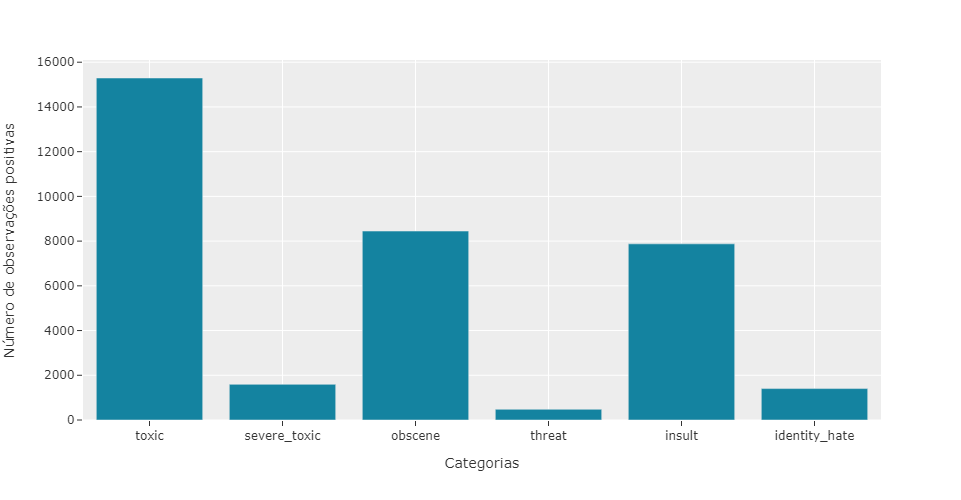

In [75]:
# Exibe gráfico com o número de obervações positivas para cada uma das categorias que iremos prever

counts = df.select_dtypes('int64').sum().values
categories = df.select_dtypes('int64').sum().index

label = {'x':'Categorias', 'y':'Número de observações positivas'}

fig = px.bar(x = categories, y = counts, labels = label, template='ggplot2')
fig.update_traces(marker_color='#1483A0')
fig.update_yaxes(tickformat=".6")
fig.update_layout(width = 700, height = 500)
fig.show()

Claramente estamos trabalhando com um conjunto de dados muito desbalanceado o que implica em alguns cuidados na hora de treinarmos o modelo e avalia-lo.

Cada vez que rodarmos a função abaixo poderemos verificar um dos comentários presente no conjunto de dados e assim avaliarmos algumas técincas de limpeza e criação de vocabulário. A análise dos dados crus é uma etapa muito importante e deve ser feita de forma minusciosa. Abaixo deixarei apenas a exibição de um único comentário, contudo asseguro que passamos por diversas observações do banco de dados.

In [77]:
show_reviews(df)

Suck my greasy dick, I will start creating thousands of pages using different names and you can eat the corn out of my shit if you like.  I can create far more than you can ever delete.  I will use various screennames, various site titles, and all so don't fuck with me you split lip bitch.

       toxic  severe_toxic  obscene  threat  insult  identity_hate
59411      1             0        0       0       0              0


A seguir vamos criar um protótipo de vocabulário de forma avaliarmos a divisão dos dados. Para isto iremos utilizar a função de limpeza de dados `clean_text_3`.

In [85]:
df['comment_text'] = df['comment_text'].apply(clean_text)

In [86]:
show_most_frequent_words(df, n_words = 20)

[('fuck', 8673), ('dont', 3844), ('like', 3767), ('shit', 3653), ('wikipedia', 3481), ('nigger', 3295), ('fucking', 3238), ('suck', 3048), ('go', 2931), ('ass', 2654)]


# Limpeza dos Dados e Criação dos Vocabulários

Nesta seção iremos realizar a limpeza e preparação dos dados para serem passados para os modelos de machine learning. Como o dataset que estamos trabalhando é pequeno e ocupa pouco espaço em disco optei por experimentar diversos tipos de limpeza e salvar os datasets limpos em disco. Trabalhando desta forma ganhamos mais agilidade no treinamento dos modelos uma vez que, esta etapa de limpeza é bastante demorada e integra-la em um pipeline de dados junto com o treinamento dos modelos iria aumentar muito o tempo necessário de treinamento. Da forma como está sendo proposto quando da realização dos treinamentos apenas faremos o carregamento dos dados e estaremos livres para realizar experimentações em diferentes tipos de modelos com muito mais agilidade.  
É importante também que fique claro que em todas as limpezas que iremos realizar salvaremos em disco 4 conjuntos de dados, sendo estes 4 conjutos de treino e 4 conjuntos de validação, para que possamos realizar a validação cruzada dos modelos.  
Além da limpeza dos dados iremos também criar os vocabulários que serão utilizados no treinamento dos modelos. É importante perceber que estamos criando 4 vocabulários, sendo um para cada divisão que está sendo proposta, lembrando que, para evitar vazamento de dados, os vocabulários são criados utilizando apenas o conjunto de treino.

## Limpeza

Nesta primeira etapa estaremos realizando uma limpeza básica dos dados. Para verificar os detalhes da limpeza executada basta ver a documentação da função `clean_text` e acompanhar os comentários feitos no código abaixo. 

In [24]:
# Carrega todos os dados em um data frame
df = pd.read_csv('dados/train.csv/train.csv')

n_folds = 4

for i in range(n_folds):
    
    print('Fold {} - Processando...'.format(i))
    
    # Reparte os dados em conjuntos de treino e validação
    df_train, df_val = train_test_split(df, test_size = 0.2, random_state = i)    
    
    # Limpa e tokeniza o texto
    df_train['comment_text'] = df_train['comment_text'].apply(clean_text)
    df_val['comment_text'] = df_val['comment_text'].apply(clean_text)
    
    # Criando o vocabulário
    counter = Counter()
    for list_of_tokens in df_train['comment_text']:
        create_vocab(list_of_tokens, counter)
        
    # Exclui as palavras com menor frquência do vocabulário
    vocab = [word for word, frequency in counter.items() if frequency > 5]
    
    # Exibe o tamanho final do vocabulário
    print('Tamanho do Vocabulário, fold número_{}: {}'.format(i, len(vocab)))
    
    # Salva o vocabulário
    save_list(vocab, 'vocabulários/limpeza/vocabulary_{}.txt'.format(i))
    
    # Filtra os arquivos de texto para que só tenham palavras do vocabulário
    df_train['comment_text'] = df_train['comment_text'].apply(process_text, vocab = vocab)
    df_val['comment_text'] = df_val['comment_text'].apply(process_text, vocab = vocab)
    
    # Une os tokens de cada texto em uma única string
    df_train['comment_text'] = df_train['comment_text'].apply(join_string)
    df_val['comment_text'] = df_val['comment_text'].apply(join_string)
    
    # Salva os dados processados em disco
    df_train.to_pickle('dados/dados_limpos/train_tokenized_{}.pkl'.format(i))
    df_val.to_pickle('dados/dados_limpos/val_tokenized_{}.pkl'.format(i))

Fold 0 - Processando...
Tamanho do Vocabulário, fold número_0: 31364
Fold 1 - Processando...
Tamanho do Vocabulário, fold número_1: 31406
Fold 2 - Processando...
Tamanho do Vocabulário, fold número_2: 31346
Fold 3 - Processando...
Tamanho do Vocabulário, fold número_3: 31389


## Sem Limpeza

Nos conjuntos de dados criados abaixo não iremos executar nenhum tipo de limpeza especial nos dados, para verificar os detalhes ver documentação da função `clean_text_2`

In [32]:
# Carrega todos os dados em um data frame
df = pd.read_csv('dados/train.csv/train.csv')

n_folds = 4

for i in range(n_folds):
    
    print('Fold {} - Processando...'.format(i))
    
    # Reparte os dados em conjuntos de treino e validação e salva em disco os dados
    df_train, df_val = train_test_split(df, test_size = 0.2, random_state = i)
    
    # Limpa e tokeniza o texto
    df_train['comment_text'] = df_train['comment_text'].apply(clean_text_2)
    df_val['comment_text'] = df_val['comment_text'].apply(clean_text_2)
    
    # Une os tokens de cada texto em uma única string
    df_train['comment_text'] = df_train['comment_text'].apply(join_string)
    df_val['comment_text'] = df_val['comment_text'].apply(join_string)
    
    # Salva os dados processados no disco
    df_train.to_pickle('dados/dados_s_limpeza/train_tokenized_{}.pkl'.format(i))
    df_val.to_pickle('dados/dados_s_limpeza/val_tokenized_{}.pkl'.format(i))

Fold 0 - Processando...
Fold 1 - Processando...
Fold 2 - Processando...
Fold 3 - Processando...


## Muita Limpeza

No código abaixo estaremos realizando uma limpeza mais pesada dos dados, com a utilização de diversos códigos em regex. Para mais detalhes ver a documentação da função `clean_text_3`

In [24]:
# Carrega todos os dados em um data frame
df = pd.read_csv('dados/train.csv/train.csv')

n_folds = 4

for i in range(n_folds):
    
    print('Fold {} - Processando...'.format(i))
    
    # Reparte os dados em conjuntos de treino e validação e salva em disco os dados
    df_train, df_val = train_test_split(df, test_size = 0.2, random_state = i)    
    
    # Limpa e tokeniza o texto
    df_train['comment_text'] = df_train['comment_text'].apply(clean_text_3)
    df_val['comment_text'] = df_val['comment_text'].apply(clean_text_3)
    
    
    # Criando o vocabulário
    counter = Counter()
    for list_of_tokens in df_train['comment_text']:
        create_vocab(list_of_tokens, counter)
        
    # Exclui as palavras com menor frquência do vocabulário
    vocab = [word for word, frequency in counter.items() if frequency > 5]
    
    # Exibe o tamanho final do vocabulário
    print('Tamanho do Vocabulário, fold número_{}: {}'.format(i, len(vocab)))
    
    # Salva o vocabulário
    save_list(vocab, 'vocabulários/limpeza_3/vocabulary_{}.txt'.format(i))
    
    # Filtra os arquivos de texto para que só tenham palavras do vocabulário
    df_train['comment_text'] = df_train['comment_text'].apply(process_text, vocab = vocab)
    df_val['comment_text'] = df_val['comment_text'].apply(process_text, vocab = vocab)
    
    # Une os tokens de cada texto em uma única string
    df_train['comment_text'] = df_train['comment_text'].apply(join_string)
    df_val['comment_text'] = df_val['comment_text'].apply(join_string)
    
    # Salva os dados processados no disco
    df_train.to_pickle('dados/dados_limpos_3/train_tokenized_{}.pkl'.format(i))
    df_val.to_pickle('dados/dados_limpos_3/val_tokenized_{}.pkl'.format(i))

Fold 0 - Processando...
Tamanho do Vocabulário, fold número_0: 31103
Fold 1 - Processando...
Tamanho do Vocabulário, fold número_1: 31155
Fold 2 - Processando...
Tamanho do Vocabulário, fold número_2: 31224
Fold 3 - Processando...
Tamanho do Vocabulário, fold número_3: 31147


## Muita Limpeza e maior vocabulário

No código abaixo iremos utilizar a mesma limpeza da seção acima com a função `clean_text_3`, contudo iremos aumentar o vocabulário uma vez que iremos descartar apenas tokens que tenham uma frequência menor ou igual a 2, o que difere da limpeza anterior onde foram descartados tokens com frequencia menor ou igual a 5.

In [24]:
# Carrega todos os dados em um data frame
df = pd.read_csv('dados/train.csv/train.csv')

n_folds = 4

for i in range(n_folds):
    
    print('Fold {} - Processando...'.format(i))
    
    # Reparte os dados em conjuntos de treino e validação e salva em disco os dados
    df_train, df_val = train_test_split(df, test_size = 0.2, random_state = i)    
    
    # Limpa e tokeniza o texto
    df_train['comment_text'] = df_train['comment_text'].apply(clean_text_3)
    df_val['comment_text'] = df_val['comment_text'].apply(clean_text_3)
    
    
    # Criando o vocabulário
    counter = Counter()
    for list_of_tokens in df_train['comment_text']:
        create_vocab(list_of_tokens, counter)
        
    # Exclui as palavras com menor frquência do vocabulário
    vocab = [word for word, frequency in counter.items() if frequency > 2]
    
    # Exibe o tamanho final do vocabulário
    print('Tamanho do Vocabulário, fold número_{}: {}'.format(i, len(vocab)))
    
    # Salva o vocabulário
    save_list(vocab, 'vocabulários/limpeza_4/vocabulary_{}.txt'.format(i))
    
    # Filtra os arquivos de texto para que só tenham palavras do vocabulário
    df_train['comment_text'] = df_train['comment_text'].apply(process_text, vocab = vocab)
    df_val['comment_text'] = df_val['comment_text'].apply(process_text, vocab = vocab)
    
    # Une os tokens de cada texto em uma única string
    df_train['comment_text'] = df_train['comment_text'].apply(join_string)
    df_val['comment_text'] = df_val['comment_text'].apply(join_string)
    
    # Salva os dados processados no disco
    df_train.to_pickle('dados/dados_limpos_4/train_tokenized_{}.pkl'.format(i))
    df_val.to_pickle('dados/dados_limpos_4/val_tokenized_{}.pkl'.format(i))

Fold 0 - Processando...
Tamanho do Vocabulário, fold número_0: 50510
Fold 1 - Processando...
Tamanho do Vocabulário, fold número_1: 50514
Fold 2 - Processando...
Tamanho do Vocabulário, fold número_2: 50518
Fold 3 - Processando...
Tamanho do Vocabulário, fold número_3: 50527


## Muita Limpeza e pre-trained GloVe 25d

No código abaixo iremos utilizar a função de limpeza `clean_text_3`, manteremos o vocabulário maior e iremos criar também uma matriz de embeddings que será utilizada no treinamento das redes neurais. Para a criação da matriz de embeddings vamos carregar embeddings pre-treinados com o algorítimo GloVe, estes embeddings podem ser obtidos no link a seguir: https://nlp.stanford.edu/projects/glove/.  
No caso deste trabalho estamos utilizando os embeddings treinados com 2 bilhões tweets, o que gerou um vocabulários de 1.2 milhões de palavras. Nesta limpeza foram utilizados embeddings com dimensão igual a 25.

In [24]:
# Carrega todos os dados em um data frame
df = pd.read_csv('dados/train.csv/train.csv')

n_folds = 4

# Carrega o Word Embedding
embedding_dict = dict()
file = open('word_embedding/GloVe/glove.twitter.27B.25d.txt', encoding = 'utf-8')
for line in file:
    values = line.split()
    words = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_dict[words] = coefs  
file.close()
        

for i in range(n_folds):
    
    print('Fold {} - Processando...'.format(i))
    
    # Reparte os dados em conjuntos de treino e validação e salva em disco os dados
    df_train, df_val = train_test_split(df, test_size = 0.2, random_state = i)    
    
    # Limpa e tokeniza o texto
    df_train['comment_text'] = df_train['comment_text'].apply(clean_text_3)
    df_val['comment_text'] = df_val['comment_text'].apply(clean_text_3)
    
    
    # Criando o vocabulário
    counter = Counter()
    for list_of_tokens in df_train['comment_text']:
        create_vocab(list_of_tokens, counter)
        
    # Exclui as palavras com menor frquência do vocabulário
    vocab = [word for word, frequency in counter.items() if frequency > 2]
    
    # Cria a matrix de embbeding e o word index
    embedding_matrix = np.zeros((2,25))
    word_index = []
    for word in vocab:
        weight = embedding_dict.get(word, None)
        if weight is not None:        
            weight = np.expand_dims(weight, axis = 0)
            embedding_matrix = np.concatenate([embedding_matrix, weight])
            word_index.append(word)
    np.save('vocabulários/limpeza_5/weights_{}.npy'.format(i), embedding_matrix, allow_pickle=False)
             
    # Exibe o tamanho final do vocabulário
    print('Tamanho do Vocabulário, fold número_{}: {}'.format(i, len(word_index)))
    
    # Salva o vocabulário
    save_list(word_index, 'vocabulários/limpeza_5/vocabulary_{}.txt'.format(i))
    
    # Filtra os arquivos de texto para que só tenham palavras do vocabulário
    df_train['comment_text'] = df_train['comment_text'].apply(process_text, vocab = word_index)
    df_val['comment_text'] = df_val['comment_text'].apply(process_text, vocab = word_index)
    
    # Une os tokens de cada texto em uma única string
    df_train['comment_text'] = df_train['comment_text'].apply(join_string)
    df_val['comment_text'] = df_val['comment_text'].apply(join_string)
    
    # Salva os dados processados no disco
    df_train.to_pickle('dados/dados_limpos_5/train_tokenized_{}.pkl'.format(i))
    df_val.to_pickle('dados/dados_limpos_5/val_tokenized_{}.pkl'.format(i))

Fold 0 - Processando...
Tamanho do Vocabulário, fold número_0: 40941
Fold 1 - Processando...
Tamanho do Vocabulário, fold número_1: 40989
Fold 2 - Processando...
Tamanho do Vocabulário, fold número_2: 40953
Fold 3 - Processando...
Tamanho do Vocabulário, fold número_3: 40948


## Muita Limpeza + lematização + pre-trained GloVe 25d

No código abaixo iremos manter o mesmo tratamento que foi dado na seção acima, contudo iremos aplicar a lematização dos tokens. A lematização é um algorítmo que realiza a transformação de palavras de forma a reduzir a palavra a sua raiz, por exemplo para o token "cats" um algorítimo de lemmatização iria retornar "cat". Para aplicação da lemmatização vamos utilizar a função `clean_text_4` que é igual a `clean_text_3` contudo possui a aplicação de um algorítmos de lematização.

In [36]:
# Carrega todos os dados em um data frame
df = pd.read_csv('dados/train.csv/train.csv')

n_folds = 4

lematizer = nltk.stem.wordnet.WordNetLemmatizer()

# Carrega o Word Embedding
embedding_dict = dict()
file = open('word_embedding/GloVe/glove.twitter.27B.25d.txt', encoding = 'utf-8')
for line in file:
    values = line.split()
    words = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_dict[words] = coefs  
file.close()

for i in range(n_folds):
    
    print('Fold {} - Processando...'.format(i))
    
    # Reparte os dados em conjuntos de treino e validação e salva em disco os dados
    df_train, df_val = train_test_split(df, test_size = 0.2, random_state = i)    
    
    # Limpa e tokeniza o texto
    df_train['comment_text'] = df_train['comment_text'].apply(clean_text_4, lematizer = lematizer)
    df_val['comment_text'] = df_val['comment_text'].apply(clean_text_4, lematizer = lematizer)
    
    
    # Criando o vocabulário
    counter = Counter()
    for list_of_tokens in df_train['comment_text']:
        create_vocab(list_of_tokens, counter)
        
    # Exclui as palavras com menor frquência do vocabulário
    vocab = [word for word, frequency in counter.items() if frequency > 2]
    
    # Cria a matrix de embbeding e o word index
    embedding_matrix = np.zeros((2,25))
    word_index = []
    for word in vocab:
        weight = embedding_dict.get(word, None)
        if weight is not None:        
            weight = np.expand_dims(weight, axis = 0)
            embedding_matrix = np.concatenate([embedding_matrix, weight])
            word_index.append(word)
    np.save('vocabulários/limpeza_6/weights_{}.npy'.format(i), embedding_matrix, allow_pickle=False)
             
    # Exibe o tamanho final do vocabulário
    print('Tamanho do Vocabulário, fold número_{}: {}'.format(i, len(word_index)))
    
    # Salva o vocabulário
    save_list(word_index, 'vocabulários/limpeza_6/vocabulary_{}.txt'.format(i))
    
    # Filtra os arquivos de texto para que só tenham palavras do vocabulário
    df_train['comment_text'] = df_train['comment_text'].apply(process_text, vocab = word_index)
    df_val['comment_text'] = df_val['comment_text'].apply(process_text, vocab = word_index)
    
    # Une os tokens de cada texto em uma única string
    df_train['comment_text'] = df_train['comment_text'].apply(join_string)
    df_val['comment_text'] = df_val['comment_text'].apply(join_string)
    
    # Salva os dados processados no disco
    df_train.to_pickle('dados/dados_limpos_6/train_tokenized_{}.pkl'.format(i))
    df_val.to_pickle('dados/dados_limpos_6/val_tokenized_{}.pkl'.format(i))

Fold 0 - Processando...
Tamanho do Vocabulário, fold número_0: 36391
Fold 1 - Processando...
Tamanho do Vocabulário, fold número_1: 36386
Fold 2 - Processando...
Tamanho do Vocabulário, fold número_2: 36370
Fold 3 - Processando...
Tamanho do Vocabulário, fold número_3: 36376


## Muita Limpeza + pre-trained GloVe 50d

No código abaixo iremos utilizar a função de limpeza `clean_text_3`, manteremos o vocabulário maior e iremos criar a matriz de embedding com vetores de dimensão igual a 50.

In [25]:
# Carrega todos os dados em um data frame
df = pd.read_csv('dados/train.csv/train.csv')

n_folds = 4

# Carrega o Word Embedding
embedding_dict = dict()
file = open('word_embedding/GloVe/glove.twitter.27B.50d.txt', encoding = 'utf-8')
for line in file:
    values = line.split()
    words = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_dict[words] = coefs  
file.close()
        

for i in range(n_folds):
    
    print('Fold {} - Processando...'.format(i))
    
    # Reparte os dados em conjuntos de treino e validação e salva em disco os dados
    df_train, df_val = train_test_split(df, test_size = 0.2, random_state = i)    
    
    # Limpa e tokeniza o texto
    df_train['comment_text'] = df_train['comment_text'].apply(clean_text_3)
    df_val['comment_text'] = df_val['comment_text'].apply(clean_text_3)
    
    
    # Criando o vocabulário
    counter = Counter()
    for list_of_tokens in df_train['comment_text']:
        create_vocab(list_of_tokens, counter)
        
    # Exclui as palavras com menor frquência do vocabulário
    vocab = [word for word, frequency in counter.items() if frequency > 2]
    
    # Cria a matrix de embbeding e o word index
    embedding_matrix = np.zeros((2,50))
    word_index = []
    for word in vocab:
        weight = embedding_dict.get(word, None)
        if weight is not None:        
            weight = np.expand_dims(weight, axis = 0)
            embedding_matrix = np.concatenate([embedding_matrix, weight])
            word_index.append(word)
    np.save('vocabulários/limpeza_7/weights_{}.npy'.format(i), embedding_matrix, allow_pickle=False)
             
    # Exibe o tamanho final do vocabulário
    print('Tamanho do Vocabulário, fold número_{}: {}'.format(i, len(word_index)))
    
    # Salva o vocabulário
    save_list(word_index, 'vocabulários/limpeza_7/vocabulary_{}.txt'.format(i))
    
    # Filtra os arquivos de texto para que só tenham palavras do vocabulário
    df_train['comment_text'] = df_train['comment_text'].apply(process_text, vocab = word_index)
    df_val['comment_text'] = df_val['comment_text'].apply(process_text, vocab = word_index)
    
    # Une os tokens de cada texto em uma única string
    df_train['comment_text'] = df_train['comment_text'].apply(join_string)
    df_val['comment_text'] = df_val['comment_text'].apply(join_string)
    
    # Salva os dados processados no disco
    df_train.to_pickle('dados/dados_limpos_7/train_tokenized_{}.pkl'.format(i))
    df_val.to_pickle('dados/dados_limpos_7/val_tokenized_{}.pkl'.format(i))

Fold 0 - Processando...
Tamanho do Vocabulário, fold número_0: 40941
Fold 1 - Processando...
Tamanho do Vocabulário, fold número_1: 40989
Fold 2 - Processando...
Tamanho do Vocabulário, fold número_2: 40953
Fold 3 - Processando...
Tamanho do Vocabulário, fold número_3: 40948


## Muita Limpeza + pre-trained GloVe 100d

No código abaixo iremos utilizar a função de limpeza `clean_text_3`, manteremos o vocabulário maior e iremos criar a matriz de embedding com vetores de dimensão igual a 100.

In [47]:
# Carrega todos os dados em um data frame
df = pd.read_csv('dados/train.csv/train.csv')

n_folds = 4

# Carrega o Word Embedding
embedding_dict = dict()
file = open('word_embedding/GloVe/glove.twitter.27B.100d.txt', encoding = 'utf-8')
for line in file:
    values = line.split()
    words = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_dict[words] = coefs  
file.close()
        

for i in range(n_folds):
    
    print('Fold {} - Processando...'.format(i))
    
    # Reparte os dados em conjuntos de treino e validação e salva em disco os dados
    df_train, df_val = train_test_split(df, test_size = 0.2, random_state = i)    
    
    # Limpa e tokeniza o texto
    df_train['comment_text'] = df_train['comment_text'].apply(clean_text_3)
    df_val['comment_text'] = df_val['comment_text'].apply(clean_text_3)
    
    
    # Criando o vocabulário
    counter = Counter()
    for list_of_tokens in df_train['comment_text']:
        create_vocab(list_of_tokens, counter)
        
    # Exclui as palavras com menor frquência do vocabulário
    vocab = [word for word, frequency in counter.items() if frequency > 2]
    
    # Cria a matrix de embbeding e o word index
    embedding_matrix = np.zeros((2,100))
    word_index = []
    for word in vocab:
        weight = embedding_dict.get(word, None)
        if weight is not None:        
            weight = np.expand_dims(weight, axis = 0)
            embedding_matrix = np.concatenate([embedding_matrix, weight])
            word_index.append(word)
    np.save('vocabulários/limpeza_8/weights_{}.npy'.format(i), embedding_matrix, allow_pickle=False)
             
    # Exibe o tamanho final do vocabulário
    print('Tamanho do Vocabulário, fold número_{}: {}'.format(i, len(word_index)))
    
    # Salva o vocabulário
    save_list(word_index, 'vocabulários/limpeza_8/vocabulary_{}.txt'.format(i))
    
    # Filtra os arquivos de texto para que só tenham palavras do vocabulário
    df_train['comment_text'] = df_train['comment_text'].apply(process_text, vocab = word_index)
    df_val['comment_text'] = df_val['comment_text'].apply(process_text, vocab = word_index)
    
    # Une os tokens de cada texto em uma única string
    df_train['comment_text'] = df_train['comment_text'].apply(join_string)
    df_val['comment_text'] = df_val['comment_text'].apply(join_string)
    
    # Salva os dados processados no disco
    df_train.to_pickle('dados/dados_limpos_8/train_tokenized_{}.pkl'.format(i))
    df_val.to_pickle('dados/dados_limpos_8/val_tokenized_{}.pkl'.format(i))

Fold 0 - Processando...
Tamanho do Vocabulário, fold número_0: 40941
Fold 1 - Processando...
Tamanho do Vocabulário, fold número_1: 40989
Fold 2 - Processando...
Tamanho do Vocabulário, fold número_2: 40953
Fold 3 - Processando...
Tamanho do Vocabulário, fold número_3: 40948


# Modelagem

Nesta seção iremos treinar os modelos de machine learning. Neste trabalho daremos foco a modelos criados com redes neurais profundas. Peço que verifiquem abaixo algumas das metodologias utilizadas para avaliação dos modelos:  

1. Os resultados de todos os modelos treinados serão exibidos para cada um dos folds avaliados.
2. Para todos os modelos iremos calcular as métricas: Precision, Recall, F1, ROC AUC e Precision-Recall AUC.
3. A média destas métricas em todos os folds serão armazenadas em um arquivo excel para facilitar a busca e comparação dos resultados posteriormente.

É importante que fique claro que neste trabalho iremos focar nossa atenção na métrica Precision-Recall AUC, esta métrica realizar a medida da área embaixo da curva Precision-Recall do modelo. Para o caso deste dataset, que é altamente desbalanceado, o ideal é utilizarmos esta métrica em detrimento de outras como é o caso da ROC AUC. É sabido que a métrica ROC AUC é bastante robusta quando estamos utilizando dados desbalanceados, contudo em casos mais extremos, como este, esta métrica pode superestimar o desempenho do modelo dando a falsa impressão de boa performance. Ao longo deste trabalho iremos comparar os resultados obtidos e verificar que a métrica que estamos utilizando é mais adequada.

## Modelo 1 - MLP + Limpeza

O primeiro modelo que iremos treinar será um multi layer perceptron. Este é o modelo mais básico possível. Para alimentarmos esta rede neural vamos utilizar o modelo _bag of words_. Esta forma de encoding dos dados textuais consiste em criarmos uma tabela onde as colunas representam cada um dos tokens do nosso vocabulário e as linhas irão indicar a existência ou não (1 ou 0) de determinado token do texto que está sendo passado para a rede.

In [44]:
# A função abaixo cria o modelo.
def get_model_1(vectorizer):
    
    model = Sequential()
    model.add(Input(shape = (1,), dtype = tf.string))
    model.add(vectorizer)
    model.add(Dense(units = 50, activation = 'relu'))
    model.add(Dense(units = 6, activation = 'sigmoid'))
    
    return model

# Determina o número de folds que iremos treinar e avaliar o modelo
n_folds = 4

# Determina as métricas que serão calculadas pelo tensorflow durante o treinamento. Lembrando que todas as métricas serão calculadas ao final do treinamento
# pela função evaluate_model
METRICS = [
     AUC(name = 'auc'), 
     Precision(name = 'precision'), 
     Recall(name = 'recall')]



for i in range(n_folds):
    
    print('Treinando modelo no fold {}...'.format(i))
    
    # Carregando os dados tokenizados
    df_train = pd.read_pickle('dados/dados_limpos/train_tokenized_{}.pkl'.format(i))
    df_val = pd.read_pickle('dados/dados_limpos/val_tokenized_{}.pkl'.format(i))
    
    # Cria o vetorizador de texto
    vectorizer = create_vectorizer(df_train['comment_text'], output_mode = 'multi_hot')
    print('Tamanho do vocabulário do vetorizador fold {}: {}'.format(i, len(vectorizer.get_vocabulary())))
    
    # Prepara os dados
    Xtrain = df_train.loc[:, 'comment_text'].values
    ytrain = df_train.loc[:, ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
    Xval = df_val.loc[:, 'comment_text'].values
    yval = df_val.loc[:, ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
    
    # Treina o modelo
    callbacks = [EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights = True), CSVLogger(filename = 'models/model_1/hist/train_log_{}.csv'.format(i))]
    model_1 = get_model_1(vectorizer)
    model_1.compile(optimizer = 'adam', loss = 'BinaryCrossentropy', metrics = METRICS)
    model_1.fit(Xtrain, ytrain, batch_size = 1024, epochs = 20, verbose = 0, validation_data = (Xval, yval), callbacks = callbacks)
       
    # Avalia o modelo
    print('Train score:')
    predictions = model_1.predict(Xtrain, verbose = 0)
    evaluate_model(predictions = predictions, y = ytrain, model_name = 'MLP + Limpeza')
    print('Val score:')
    predictions = model_1.predict(Xval, verbose = 0)
    if i == 0:
        result = evaluate_model(predictions = predictions, y = yval, model_name = 'MLP + Limpeza')
        results = result.copy()
    else:
        result = evaluate_model(predictions = predictions, y = yval, model_name = 'MLP + Limpeza')
        results.iloc[:,0:-1] = results.iloc[:,0:-1] + result.iloc[:,0:-1]
    print('\n')
        
results.iloc[:,0:-1] = results.iloc[:,0:-1]/n_folds

Treinando modelo no fold 0...
Tamanho do vocabulário do vetorizador fold 0: 31365
Train score:
Model's ROC AUC: 0.995
Model's PR AUC: 0.927
Val score:
Model's ROC AUC: 0.969
Model's PR AUC: 0.777


Treinando modelo no fold 1...
Tamanho do vocabulário do vetorizador fold 1: 31407
Train score:
Model's ROC AUC: 0.994
Model's PR AUC: 0.912
Val score:
Model's ROC AUC: 0.969
Model's PR AUC: 0.773


Treinando modelo no fold 2...
Tamanho do vocabulário do vetorizador fold 2: 31347
Train score:
Model's ROC AUC: 0.993
Model's PR AUC: 0.915
Val score:
Model's ROC AUC: 0.966
Model's PR AUC: 0.776


Treinando modelo no fold 3...
Tamanho do vocabulário do vetorizador fold 3: 31390
Train score:
Model's ROC AUC: 0.991
Model's PR AUC: 0.891
Val score:
Model's ROC AUC: 0.966
Model's PR AUC: 0.771




In [114]:
# Salva os resultados da avaliação do modelo em um arquivo excel
results.to_excel('model_performance_log.xlsx')

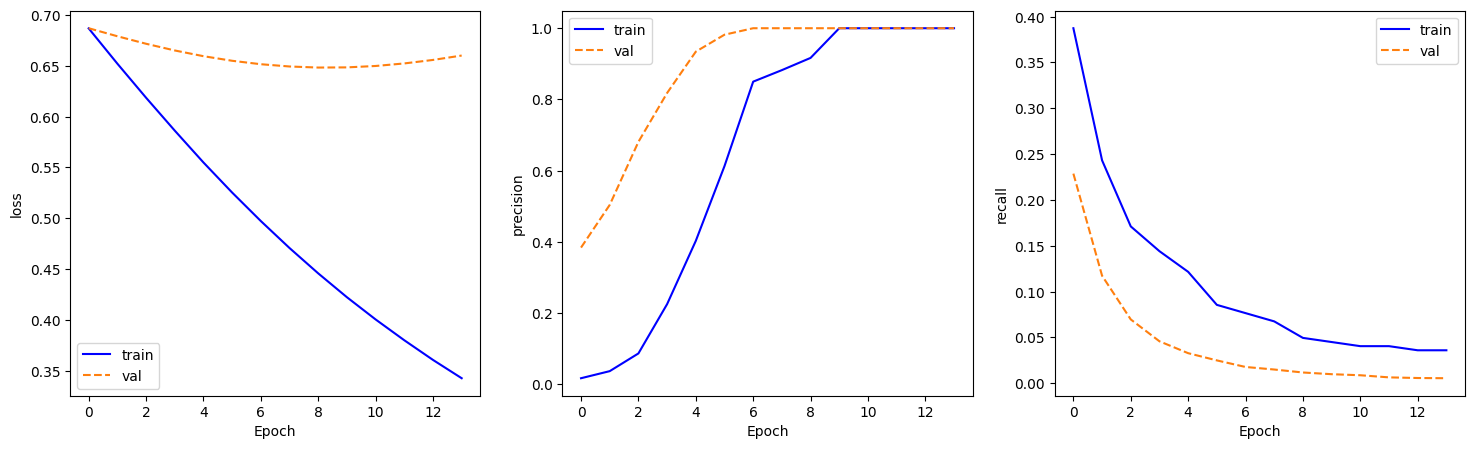

In [88]:
# Carrega o log de treinamento do modelo 1 no fold 0
history = pd.read_csv('models/model_1/hist/train_log_0.csv')

# Plota as learning curvs do modelo
plot_history(history)

Analisando os resultados podemos verificar que o modelo está sofrendo bastante com overfiting. Além disso é legal verificar as diferênças entre as métricas ROC AUC e PR AUC, veja que no fold 0 o ROC AUC para o conjunto de validação foi de 0,969 o que aparenta ser muito bom, contudo, se olharmos para as curvas de aprendizado do modelo observamos claramente que o treinamento não foi tão efetivo, e que inclusive a métrica recall decresceu com o passar das épocas. No caso da métrica PR AUC o resultado foi de 0,77 demonstrando que ainda temos um longo caminha a percorrer para melhorarmos o desempenho do modelo.

## Modelo 2 - CNN + Limpeza

Abaixo iremos incrementar um pouco o modelo utilizando agora uma rede neural convolucional. Para o encoding dos dados textuais ieremos utilizar uma camada na rede neural chamada de embedding. Esta camada é responsável por criar uma matriz de embeddings onde cada token pode ser mapeado para um vetor de valores numéricos. A matriz de embeddings pode ser teinada em conjunto com os modelos ou então pre-treinada e apenas carregada. Neste caso estamos optando por treinar a matriz de embeddings como parte do nosso modelo.

In [142]:
# A função abaixo cria o modelo.
def get_model_2(vectorizer, vocab_size):
    
    model = Sequential()
    model.add(Input(shape = (1,), dtype = tf.string))
    model.add(vectorizer)    
    model.add(Embedding(vocab_size + 1, 32))
    model.add(Conv1D(filters = 15, kernel_size = 8, activation = 'relu'))
    model.add(MaxPool1D(pool_size = 2))
    model.add(Flatten())
    model.add(Dense(10, activation = 'relu'))
    model.add(Dense(6, activation = 'sigmoid'))
    
    return model

n_folds = 4


METRICS = [AUC(name = 'auc'), 
           Precision(name = 'precision'), 
           Recall(name = 'recall')]  

output_sequence_length = 300


for i in range(n_folds):
    
    print('Treinando modelo no fold {}...'.format(i))
    
    # Carregando os dados tokenizados
    df_train = pd.read_pickle('dados/dados_limpos/train_tokenized_{}.pkl'.format(i))
    df_val = pd.read_pickle('dados/dados_limpos/val_tokenized_{}.pkl'.format(i))

    # Cria o vetorizador de texto
    vectorizer = create_vectorizer(df_train['comment_text'], output_mode = 'int', output_sequence_length = output_sequence_length)
    vocab_size = len(vectorizer.get_vocabulary())
    print('Tamanho do vocabulário do vetorizador fold {}: {}'.format(i, vocab_size))

    # Prepara os dados
    Xtrain = df_train.loc[:, 'comment_text'].values
    ytrain = df_train.loc[:, ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
    Xval = df_val.loc[:, 'comment_text'].values
    yval = df_val.loc[:, ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
    
    
    # Treina o modelo
    callbacks = [EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights = True), CSVLogger(filename = 'models/model_2/hist/train_log_{}.csv'.format(i))]
    model_2 = get_model_2(vectorizer, vocab_size)
    model_2.compile(optimizer = 'adam', loss = 'BinaryCrossentropy', metrics = METRICS)
    model_2.fit(Xtrain, ytrain, batch_size = 1024, epochs = 20, verbose = 0, validation_data = (Xval, yval), callbacks = callbacks)

    # Avalia o modelo
    print('Train score:')
    predictions = model_2.predict(Xtrain, verbose = 0)
    evaluate_model(predictions = predictions, y = ytrain, model_name = 'CNN + Limpeza')
    print('Val score:')
    predictions = model_2.predict(Xval, verbose = 0)
    if i == 0:
        result = evaluate_model(predictions = predictions, y = yval, model_name = 'CNN + Limpeza')
        results = result.copy()
    else:
        result = evaluate_model(predictions = predictions, y = yval, model_name = 'CNN + Limpeza')
        results.iloc[:,0:-1] = results.iloc[:,0:-1] + result.iloc[:,0:-1]
    print('\n')
        
results.iloc[:,0:-1] = results.iloc[:,0:-1]/n_folds

Treinando modelo no fold 0...
Tamanho do vocabulário do vetorizador fold 0: 31366
Train score:
Model's ROC AUC: 0.986
Model's PR AUC: 0.803
Val score:
Model's ROC AUC: 0.96
Model's PR AUC: 0.681


Treinando modelo no fold 1...
Tamanho do vocabulário do vetorizador fold 1: 31408
Train score:
Model's ROC AUC: 0.984
Model's PR AUC: 0.806
Val score:
Model's ROC AUC: 0.962
Model's PR AUC: 0.691


Treinando modelo no fold 2...
Tamanho do vocabulário do vetorizador fold 2: 31348
Train score:
Model's ROC AUC: 0.985
Model's PR AUC: 0.814
Val score:
Model's ROC AUC: 0.961
Model's PR AUC: 0.696


Treinando modelo no fold 3...
Tamanho do vocabulário do vetorizador fold 3: 31391
Train score:
Model's ROC AUC: 0.984
Model's PR AUC: 0.828
Val score:
Model's ROC AUC: 0.952
Model's PR AUC: 0.697




In [146]:
# Salva o modelo
model_2.save('models/model_2/model')

INFO:tensorflow:Assets written to: models/model_2/model\assets


INFO:tensorflow:Assets written to: models/model_2/model\assets


In [143]:
# Salva os resultados da avaliação do modelo em um arquivo excel
model_performance_log(results)

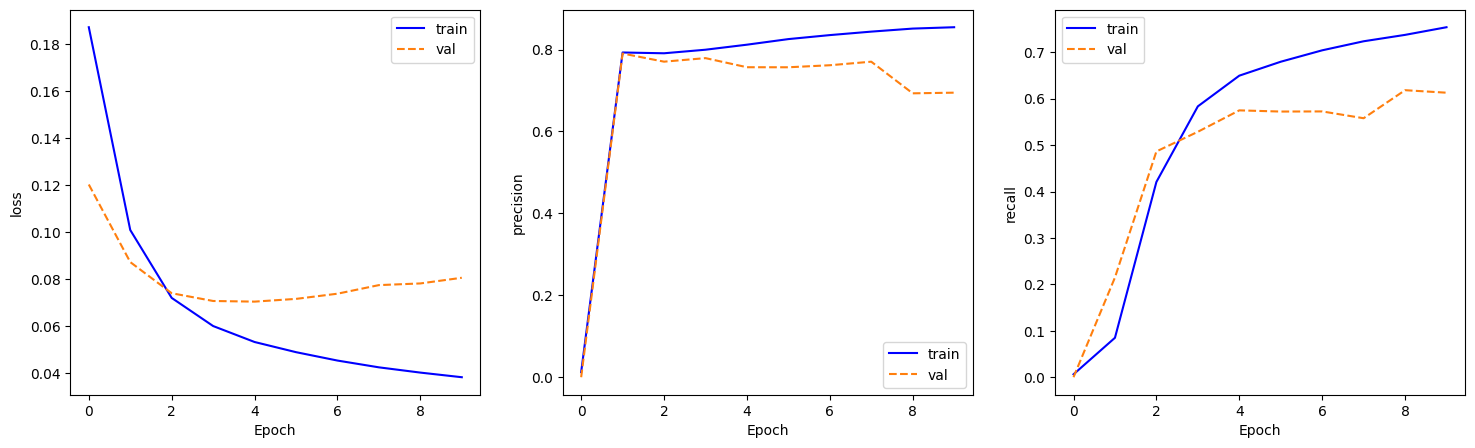

In [145]:
# Carrega o log de treinamento do modelo 2 no fold 0 (fold com melhor performance)
history = pd.read_csv('models/model_2/hist/train_log_0.csv')

# Plota as learning curvs do modelo
plot_history(history)

Observamos que em termos de overfiting tivemos uma melhora do modelo, contudo tivemos uma piora geral no desempenho do modelo.

## Modelo 3 - RNN + Limpeza

No modelo abaixo iremos utilizar uma rede neural recorrente. O encoding dos textos será igual ao encoding aplicado no modelo 2.

In [147]:
# A função abaixo cria o modelo.
def get_model_3(vectorizer, vocab):
    model = Sequential()
    model.add(Input(shape = (1,), dtype = tf.string))
    model.add(vectorizer)    
    model.add(Embedding(vocab_size + 1, 32))
    model.add(Bidirectional(LSTM(32, activation='tanh')))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(6, activation='sigmoid'))
    return model

n_folds = 4


METRICS = [AUC(name = 'auc'), 
           Precision(name = 'precision'), 
           Recall(name = 'recall')]  

output_sequence_length = 300


for i in range(n_folds):
    
    print('Treinando modelo no fold {}...'.format(i))
    
    # Carregando os dados tokenizados
    df_train = pd.read_pickle('dados/dados_limpos/train_tokenized_{}.pkl'.format(i))
    df_val = pd.read_pickle('dados/dados_limpos/val_tokenized_{}.pkl'.format(i))

    # Cria o vetorizador de texto
    vectorizer = create_vectorizer(df_train['comment_text'], output_mode = 'int', output_sequence_length = output_sequence_length)
    vocab_size = len(vectorizer.get_vocabulary())
    print('Tamanho do vocabulário do vetorizador fold {}: {}'.format(i, vocab_size))

    # Prepara os dados
    Xtrain = df_train.loc[:, 'comment_text'].values
    ytrain = df_train.loc[:, ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
    Xval = df_val.loc[:, 'comment_text'].values
    yval = df_val.loc[:, ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
    
    
    # Treina o modelo
    callbacks = [EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights = True), CSVLogger(filename = 'models/model_3/hist/train_log_{}.csv'.format(i))]
    model_3 = get_model_3(vectorizer, vocab_size)
    model_3.compile(optimizer = 'adam', loss = 'BinaryCrossentropy', metrics = METRICS)
    model_3.fit(Xtrain, ytrain, batch_size = 1024, epochs = 20, verbose = 0, validation_data = (Xval, yval), callbacks = callbacks)
    
    # Avalia o modelo
    print('Train score:')
    predictions = model_3.predict(Xtrain, verbose = 0)
    evaluate_model(predictions = predictions, y = ytrain, model_name = 'RNN + Limpeza')
    print('Val score:')
    predictions = model_3.predict(Xval, verbose = 0)
    if i == 0:
        result = evaluate_model(predictions = predictions, y = yval, model_name = 'RNN + Limpeza')
        results = result.copy()
    else:
        result = evaluate_model(predictions = predictions, y = yval, model_name = 'RNN + Limpeza')
        results.iloc[:,0:-1] = results.iloc[:,0:-1] + result.iloc[:,0:-1]
    print('\n')
        
results.iloc[:,0:-1] = results.iloc[:,0:-1]/n_folds    

Treinando modelo no fold 0...
Tamanho do vocabulário do vetorizador fold 0: 31366
Train score:
Model's ROC AUC: 0.991
Model's PR AUC: 0.863
Val score:
Model's ROC AUC: 0.978
Model's PR AUC: 0.792


Treinando modelo no fold 1...
Tamanho do vocabulário do vetorizador fold 1: 31408
Train score:
Model's ROC AUC: 0.991
Model's PR AUC: 0.87
Val score:
Model's ROC AUC: 0.974
Model's PR AUC: 0.776


Treinando modelo no fold 2...
Tamanho do vocabulário do vetorizador fold 2: 31348
Train score:
Model's ROC AUC: 0.987
Model's PR AUC: 0.841
Val score:
Model's ROC AUC: 0.975
Model's PR AUC: 0.772


Treinando modelo no fold 3...
Tamanho do vocabulário do vetorizador fold 3: 31391
Train score:
Model's ROC AUC: 0.986
Model's PR AUC: 0.837
Val score:
Model's ROC AUC: 0.976
Model's PR AUC: 0.779




In [148]:
# Salva o modelo
model_3.save('models/model_3/model')

INFO:tensorflow:Assets written to: models/model_3/model\assets


INFO:tensorflow:Assets written to: models/model_3/model\assets


In [149]:
# Salva os resultados da avaliação do modelo em um arquivo excel
model_performance_log(results)

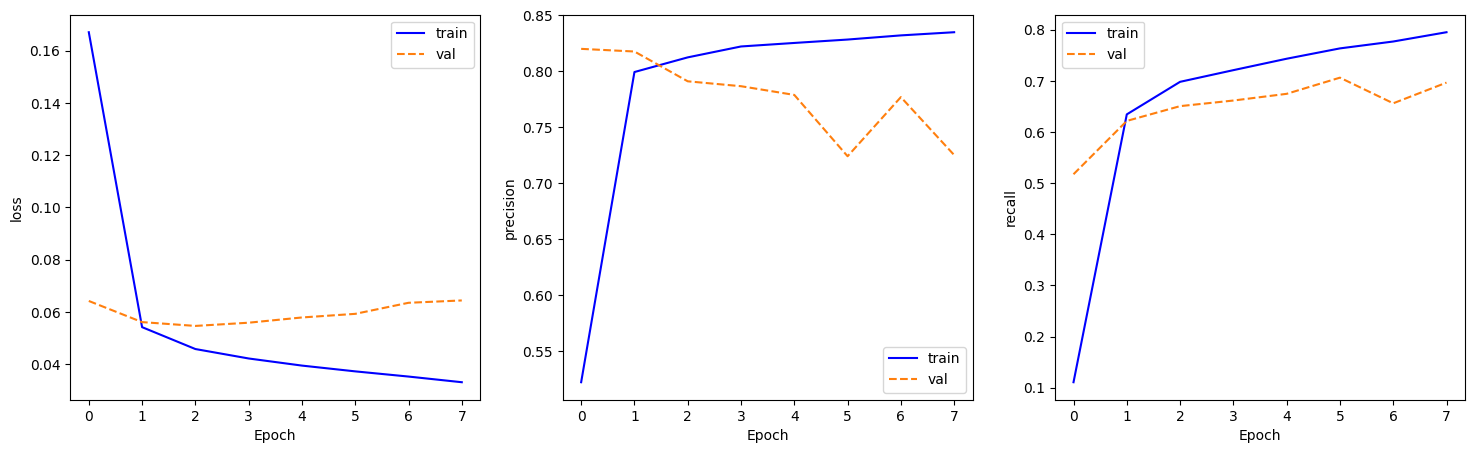

In [151]:
# Carrega o log de treinamento do modelo 3 no fold 0 (fold com melhor performance)
history = pd.read_csv('models/model_3/hist/train_log_0.csv')

# Plota as learning curvs do modelo
plot_history(history)

Observamos que a rede neural recorrente possui um desempenho melhor que as outras duas redes treinadas. As curvas de aprendizado desta rede também indicam uma melhora no processo de treinamento deste modelo.

## Modelo 4 - MultiCNN + Limpeza

Neste modelo iremos utilizar novamente as redes neurais convolucionais, contudo iremos aplicar em paralelo três camadas convolucionais, cada uma com tamanhos de kernel diferentes. A camada de embedding também está sendo utilizada e será treinada em conjunto com os pesos do modelo.

In [164]:
def get_model_4(vectorizer, vocab_size):
    
    model_input = Input(shape = (1,), dtype = tf.string)
    vect = vectorizer(model_input)
    embed = Embedding(vocab_size + 1, 32)(vect)
    
    cnn_1 = Conv1D(filters = 32, kernel_size = 4, activation = 'relu')(embed)
    cnn_1 = Dropout(0.5)(cnn_1)
    cnn_1 = MaxPool1D()(cnn_1)
    cnn_1 = Flatten()(cnn_1)
    
    cnn_2 = Conv1D(filters = 32, kernel_size = 6, activation = 'relu')(embed)
    cnn_2 = Dropout(0.5)(cnn_2)
    cnn_2 = MaxPool1D()(cnn_2)
    cnn_2 = Flatten()(cnn_2)
    
    cnn_3 = Conv1D(filters = 32, kernel_size = 8, activation = 'relu')(embed)
    cnn_3 = Dropout(0.5)(cnn_3)
    cnn_3 = MaxPool1D()(cnn_3)
    cnn_3 = Flatten()(cnn_3)
    
    merged = concatenate([cnn_1, cnn_2, cnn_3], axis = 1)
    
    dense = Dense(16, activation = 'relu')(merged)
    
    outputs = Dense(6, activation = 'sigmoid')(dense)
    
    model = Model(inputs= model_input, outputs=outputs)
    
    return model

n_folds = 4


METRICS = [AUC(name = 'auc'), 
           Precision(name = 'precision'), 
           Recall(name = 'recall')]  

output_sequence_length = 300

for i in range(n_folds):
    
    print('Treinando modelo no fold {}...'.format(i))
    
    # Carregando os dados tokenizados
    df_train = pd.read_pickle('dados/dados_limpos/train_tokenized_{}.pkl'.format(i))
    df_val = pd.read_pickle('dados/dados_limpos/val_tokenized_{}.pkl'.format(i))

    # Cria o vetorizador de texto
    vectorizer = create_vectorizer(df_train['comment_text'], output_mode = 'int', output_sequence_length = output_sequence_length)
    vocab_size = len(vectorizer.get_vocabulary())
    print('Tamanho do vocabulário do vetorizador fold {}: {}'.format(i, vocab_size))

    # Prepara os dados
    Xtrain = df_train.loc[:, 'comment_text'].values
    ytrain = df_train.loc[:, ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
    Xval = df_val.loc[:, 'comment_text'].values
    yval = df_val.loc[:, ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
    
    # Treina o modelo
    callbacks = [EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights = True), CSVLogger(filename = 'models/model_4/hist/train_log_{}.csv'.format(i))]
    model_4 = get_model_4(vectorizer, vocab_size)
    model_4.compile(optimizer = 'adam', loss = 'BinaryCrossentropy', metrics = METRICS)
    model_4.fit(Xtrain, ytrain, batch_size = 1024, epochs = 20, verbose = 0, validation_data = (Xval, yval), callbacks = callbacks)    
    
    # Avalia o modelo
    print('Train score:')
    predictions = model_4.predict(Xtrain, verbose = 0)
    evaluate_model(predictions = predictions, y = ytrain, model_name = 'MultiCNN + Limpeza')
    print('Val score:')
    predictions = model_4.predict(Xval, verbose = 0)
    if i == 0:
        result = evaluate_model(predictions = predictions, y = yval, model_name = 'MultiCNN + Limpeza')
        results = result.copy()
    else:
        result = evaluate_model(predictions = predictions, y = yval, model_name = 'MultiCNN + Limpeza')
        results.iloc[:,0:-1] = results.iloc[:,0:-1] + result.iloc[:,0:-1]
    print('\n')
        
results.iloc[:,0:-1] = results.iloc[:,0:-1]/n_folds       

Treinando modelo no fold 0...
Tamanho do vocabulário do vetorizador fold 0: 31366
Train score:
Model's ROC AUC: 0.993
Model's PR AUC: 0.877
Val score:
Model's ROC AUC: 0.959
Model's PR AUC: 0.75


Treinando modelo no fold 1...
Tamanho do vocabulário do vetorizador fold 1: 31408
Train score:
Model's ROC AUC: 0.993
Model's PR AUC: 0.862
Val score:
Model's ROC AUC: 0.966
Model's PR AUC: 0.733


Treinando modelo no fold 2...
Tamanho do vocabulário do vetorizador fold 2: 31348
Train score:
Model's ROC AUC: 0.993
Model's PR AUC: 0.881
Val score:
Model's ROC AUC: 0.963
Model's PR AUC: 0.745


Treinando modelo no fold 3...
Tamanho do vocabulário do vetorizador fold 3: 31391
Train score:
Model's ROC AUC: 0.992
Model's PR AUC: 0.875
Val score:
Model's ROC AUC: 0.968
Model's PR AUC: 0.763




In [165]:
# Salva o modelo
model_4.save('models/model_4/model')

INFO:tensorflow:Assets written to: models/model_4/model\assets


INFO:tensorflow:Assets written to: models/model_4/model\assets


In [166]:
# Salva os resultados da avaliação do modelo em um arquivo excel
model_performance_log(results)

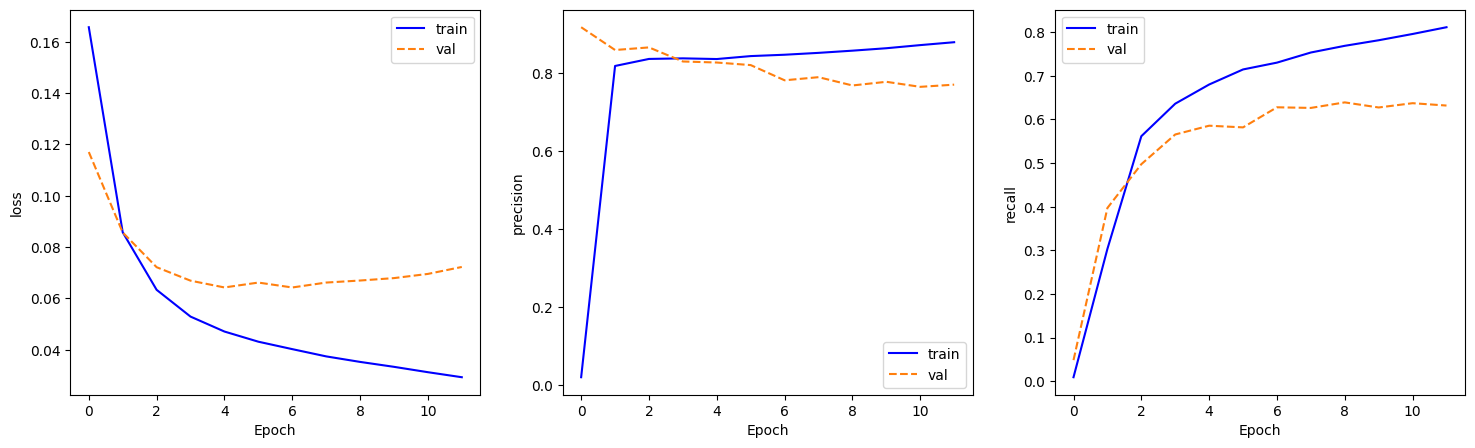

In [167]:
# Carrega o log de treinamento do modelo 3 no fold 0 (fold com melhor performance)
history = pd.read_csv('models/model_4/hist/train_log_0.csv')

# Plota as learning curvs do modelo
plot_history(history)

Os resultados acima apresentam uma melhora significativa se compararmos com os resultados do modelo 2 (que também foi construído com redes convolucionais), contudo, ainda fica atrás do modelo criado com redes recorrentes. A partir deste ponto iremos dar sequência apenas com a arquitetura do modelo 3, fazendo algumas alterações nas limpezas dos textos e vocabulários.

## Modelo 5 - RNN + Sem Limpeza

O modelo abaixo possui a mesma arquitetura do modelo 3 contudo não aplicaremos nenhum tipo de limpeza nos dados de entrada.

In [23]:
def get_model_5(vectorizer, vocab):
    model = Sequential()
    model.add(Input(shape = (1,), dtype = tf.string))
    model.add(vectorizer)    
    model.add(Embedding(vocab_size + 1, 32))
    model.add(Bidirectional(LSTM(32, activation='tanh')))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(6, activation='sigmoid'))
    return model

n_folds = 4


METRICS = [AUC(name = 'auc'), 
           Precision(name = 'precision'), 
           Recall(name = 'recall')]  

output_sequence_length = 600


for i in range(n_folds):
    
    print('Treinando modelo no fold {}...'.format(i))
    
    # Carregando os dados tokenizados
    df_train = pd.read_pickle('dados/dados_s_limpeza/train_tokenized_{}.pkl'.format(i))
    df_val = pd.read_pickle('dados/dados_s_limpeza/val_tokenized_{}.pkl'.format(i))

    # Cria o vetorizador de texto
    vectorizer = create_vectorizer(df_train['comment_text'], output_mode = 'int', output_sequence_length = output_sequence_length)
    vocab_size = len(vectorizer.get_vocabulary())
    print('Tamanho do vocabulário do vetorizador fold {}: {}'.format(i, vocab_size))

    # Prepara os dados
    Xtrain = df_train.loc[:, 'comment_text'].values
    ytrain = df_train.loc[:, ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
    Xval = df_val.loc[:, 'comment_text'].values
    yval = df_val.loc[:, ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
    
    
    # Treina o modelo
    callbacks = [EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights = True), CSVLogger(filename = 'models/model_5/hist/train_log_{}.csv'.format(i))]
    model_5 = get_model_5(vectorizer, vocab_size)
    model_5.compile(optimizer = 'adam', loss = 'BinaryCrossentropy', metrics = METRICS)
    model_5.fit(Xtrain, ytrain, batch_size = 256, epochs = 20, verbose = 0, validation_data = (Xval, yval), callbacks = callbacks)
    
    # Avalia o modelo
    print('Train score:')
    predictions = model_5.predict(Xtrain, verbose = 0)
    evaluate_model(predictions = predictions, y = ytrain, model_name = 'RNN + S/Limpeza')
    print('Val score:')
    predictions = model_5.predict(Xval, verbose = 0)
    if i == 0:
        result = evaluate_model(predictions = predictions, y = yval, model_name = 'RNN + S/Limpeza')
        results = result.copy()
    else:
        result = evaluate_model(predictions = predictions, y = yval, model_name = 'RNN + S/Limpeza')
        results.iloc[:,0:-1] = results.iloc[:,0:-1] + result.iloc[:,0:-1]
    print('\n')
        
results.iloc[:,0:-1] = results.iloc[:,0:-1]/n_folds

Treinando modelo no fold 0...
Tamanho do vocabulário do vetorizador fold 0: 109283
Train score:
Model's ROC AUC: 0.984
Model's PR AUC: 0.817
Val score:
Model's ROC AUC: 0.971
Model's PR AUC: 0.752


Treinando modelo no fold 1...
Tamanho do vocabulário do vetorizador fold 1: 109316
Train score:
Model's ROC AUC: 0.988
Model's PR AUC: 0.841
Val score:
Model's ROC AUC: 0.967
Model's PR AUC: 0.733


Treinando modelo no fold 2...
Tamanho do vocabulário do vetorizador fold 2: 109552
Train score:
Model's ROC AUC: 0.986
Model's PR AUC: 0.824
Val score:
Model's ROC AUC: 0.97
Model's PR AUC: 0.741


Treinando modelo no fold 3...
Tamanho do vocabulário do vetorizador fold 3: 108976
Train score:
Model's ROC AUC: 0.985
Model's PR AUC: 0.817
Val score:
Model's ROC AUC: 0.971
Model's PR AUC: 0.742




In [24]:
# Salva o modelo
model_5.save('models/model_5/model')

INFO:tensorflow:Assets written to: models/model_5/model\assets


INFO:tensorflow:Assets written to: models/model_5/model\assets


In [25]:
# Salva os resultados da avaliação do modelo em um arquivo excel
model_performance_log(results)

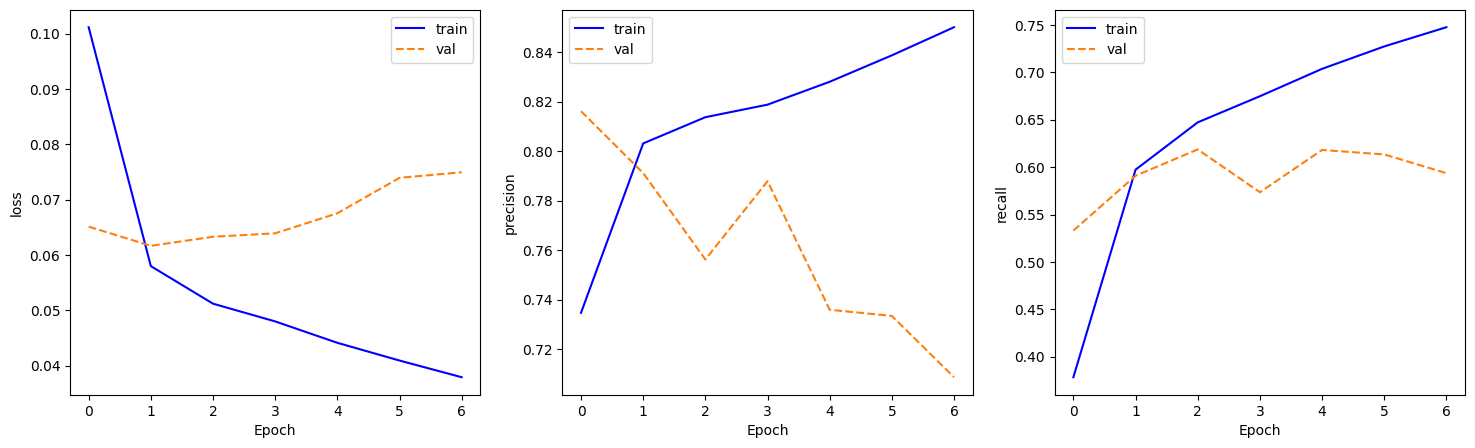

In [26]:
# Carrega o log de treinamento do modelo 3 no fold 0 (fold com melhor performance)
history = pd.read_csv('models/model_5/hist/train_log_0.csv')

# Plota as learning curvs do modelo
plot_history(history)

Se comparado com o modelo 3 tivemos uma piora nos resultados, sendo assim podemos descartar esta alternativa.

## Modelo 6 - RNN + Muita Limpeza

O modelo abaixo possui a mesma arquitetura do modelo 3 contudo faremos a aplicação de uma limpeza mais intensa nos dados.

In [25]:
def get_model_6(vectorizer, vocab):
    model = Sequential()
    model.add(Input(shape = (1,), dtype = tf.string))
    model.add(vectorizer)    
    model.add(Embedding(vocab_size + 1, 32))
    model.add(Bidirectional(LSTM(32, activation='tanh')))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(6, activation='sigmoid'))
    return model

n_folds = 4


METRICS = [AUC(name = 'auc'), 
           Precision(name = 'precision'), 
           Recall(name = 'recall')]  

output_sequence_length = 300


for i in range(n_folds):
    
    print('Treinando modelo no fold {}...'.format(i))
    
    # Carregando os dados tokenizados
    df_train = pd.read_pickle('dados/dados_limpos_3/train_tokenized_{}.pkl'.format(i))
    df_val = pd.read_pickle('dados/dados_limpos_3/val_tokenized_{}.pkl'.format(i))

    # Cria o vetorizador de texto
    vectorizer = create_vectorizer(df_train['comment_text'], output_mode = 'int', output_sequence_length = output_sequence_length)
    vocab_size = len(vectorizer.get_vocabulary())
    print('Tamanho do vocabulário do vetorizador fold {}: {}'.format(i, vocab_size))

    # Prepara os dados
    Xtrain = df_train.loc[:, 'comment_text'].values
    ytrain = df_train.loc[:, ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
    Xval = df_val.loc[:, 'comment_text'].values
    yval = df_val.loc[:, ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
    
    
    # Treina o modelo
    callbacks = [EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights = True), CSVLogger(filename = 'models/model_6/hist/train_log_{}.csv'.format(i))]
    model_6 = get_model_6(vectorizer, vocab_size)
    model_6.compile(optimizer = 'adam', loss = 'BinaryCrossentropy', metrics = METRICS)
    model_6.fit(Xtrain, ytrain, batch_size = 1024, epochs = 20, verbose = 0, validation_data = (Xval, yval), callbacks = callbacks)
    
    # Avalia o modelo
    print('Train score:')
    predictions = model_6.predict(Xtrain, verbose = 0)
    evaluate_model(predictions = predictions, y = ytrain, model_name = 'RNN + Muita Limpeza')
    print('Val score:')
    predictions = model_6.predict(Xval, verbose = 0)
    if i == 0:
        result = evaluate_model(predictions = predictions, y = yval, model_name = 'RNN + Muita Limpeza')
        results = result.copy()
    else:
        result = evaluate_model(predictions = predictions, y = yval, model_name = 'RNN + Muita Limpeza')
        results.iloc[:,0:-1] = results.iloc[:,0:-1] + result.iloc[:,0:-1]
    print('\n')
        
results.iloc[:,0:-1] = results.iloc[:,0:-1]/n_folds 

Treinando modelo no fold 0...
Tamanho do vocabulário do vetorizador fold 0: 31105
Train score:
Model's ROC AUC: 0.99
Model's PR AUC: 0.858
Val score:
Model's ROC AUC: 0.978
Model's PR AUC: 0.793


Treinando modelo no fold 1...
Tamanho do vocabulário do vetorizador fold 1: 31157
Train score:
Model's ROC AUC: 0.99
Model's PR AUC: 0.861
Val score:
Model's ROC AUC: 0.977
Model's PR AUC: 0.78


Treinando modelo no fold 2...
Tamanho do vocabulário do vetorizador fold 2: 31226
Train score:
Model's ROC AUC: 0.99
Model's PR AUC: 0.862
Val score:
Model's ROC AUC: 0.978
Model's PR AUC: 0.79


Treinando modelo no fold 3...
Tamanho do vocabulário do vetorizador fold 3: 31149
Train score:
Model's ROC AUC: 0.99
Model's PR AUC: 0.86
Val score:
Model's ROC AUC: 0.98
Model's PR AUC: 0.794




In [26]:
# Salva o modelo
model_6.save('models/model_6/model')

INFO:tensorflow:Assets written to: models/model_6/model\assets


INFO:tensorflow:Assets written to: models/model_6/model\assets


In [27]:
# Salva os resultados da avaliação do modelo em um arquivo excel
model_performance_log(results)

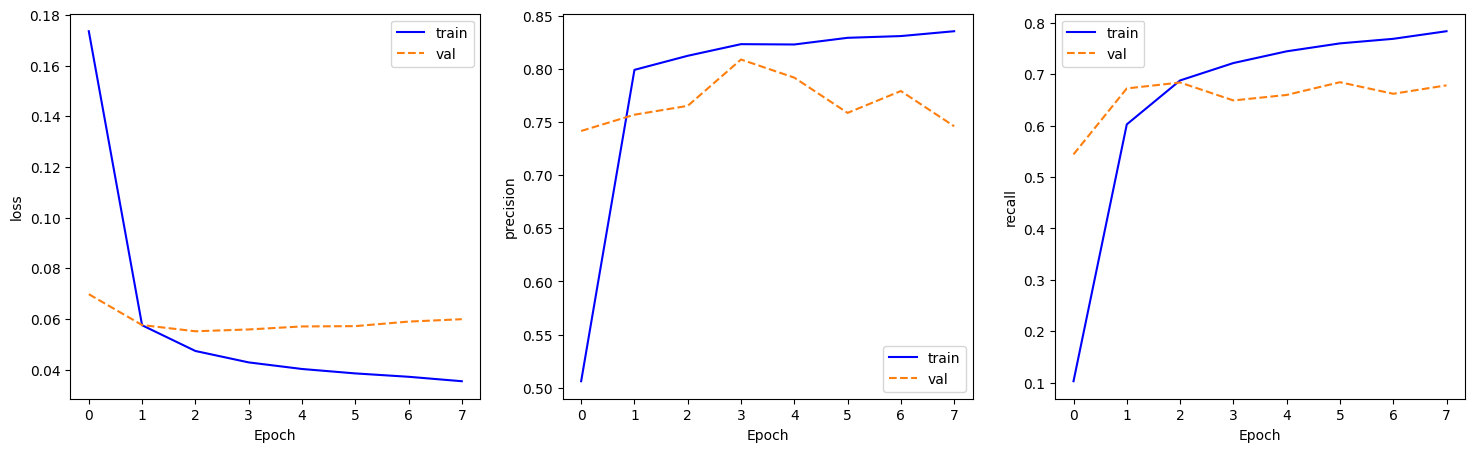

In [28]:
# Carrega o log de treinamento do modelo 3 no fold 0 (fold com melhor performance)
history = pd.read_csv('models/model_6/hist/train_log_0.csv')

# Plota as learning curvs do modelo
plot_history(history)

## Modelo 7 - RNN + Muita Limpeza + Vocab maior

O modelo abaixo possui a mesma arquitetura do modelo 3 contudo faremos a aplicação de uma limpeza mais intensa nos dados e utilizaremos um vocabulário maior (ver seção Muita Limpeza e maior vocabulário para metodologia de limpeza e criação do vocabulário)

In [62]:
def get_model_7(vectorizer, vocab):
    model = Sequential()
    model.add(Input(shape = (1,), dtype = tf.string))
    model.add(vectorizer)    
    model.add(Embedding(vocab_size + 1, 32))
    model.add(Bidirectional(LSTM(32, activation='tanh')))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(6, activation='sigmoid'))
    return model

n_folds = 4

METRICS = [AUC(name = 'auc'), 
           Precision(name = 'precision'), 
           Recall(name = 'recall')]  

output_sequence_length = 300

for i in range(n_folds):
    
    print('Treinando modelo no fold {}...'.format(i))
    
    # Carregando os dados tokenizados
    df_train = pd.read_pickle('dados/dados_limpos_5/train_tokenized_{}.pkl'.format(i))
    df_val = pd.read_pickle('dados/dados_limpos_5/val_tokenized_{}.pkl'.format(i))

    # Cria o vetorizador de texto
    vectorizer = create_vectorizer(df_train['comment_text'], output_mode = 'int', output_sequence_length = output_sequence_length)
    vocab_size = len(vectorizer.get_vocabulary())
    print('Tamanho do vocabulário do vetorizador fold {}: {}'.format(i, vocab_size))

    # Prepara os dados
    Xtrain = df_train.loc[:, 'comment_text'].values
    ytrain = df_train.loc[:, ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
    Xval = df_val.loc[:, 'comment_text'].values
    yval = df_val.loc[:, ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
    
    # Treina o modelo
    callbacks = [EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights = True), CSVLogger(filename = 'models/model_7/hist/train_log_{}.tttttttttttt.csv'.format(i))]
    model_7 = get_model_7(vectorizer, vocab_size)
    model_7.compile(optimizer = 'adam', loss = 'BinaryCrossentropy', metrics = METRICS)
    model_7.fit(Xtrain, ytrain, batch_size = 1024, epochs = 20, verbose = 0, validation_data = (Xval, yval), callbacks = callbacks)
    
    # Avalia o modelo
    print('Train score:')
    predictions = model_7.predict(Xtrain, verbose = 0)
    evaluate_model(predictions = predictions, y = ytrain, model_name = 'RNN + Muita Limpeza + Vocab')
    print('Val score:')
    predictions = model_7.predict(Xval, verbose = 0)
    if i == 0:
        result = evaluate_model(predictions = predictions, y = yval, model_name = 'RNN + Muita Limpeza + Vocab')
        results = result.copy()
    else:
        result = evaluate_model(predictions = predictions, y = yval, model_name = 'RNN + Muita Limpeza + Vocab')
        results.iloc[:,0:-1] = results.iloc[:,0:-1] + result.iloc[:,0:-1]
    print('\n')
        
results.iloc[:,0:-1] = results.iloc[:,0:-1]/n_folds 

Treinando modelo no fold 0...
Tamanho do vocabulário do vetorizador fold 0: 40943
Train score:
Model's ROC AUC: 0.99
Model's PR AUC: 0.861
Val score:
Model's ROC AUC: 0.979
Model's PR AUC: 0.797


Treinando modelo no fold 1...
Tamanho do vocabulário do vetorizador fold 1: 40991
Train score:
Model's ROC AUC: 0.991
Model's PR AUC: 0.864
Val score:
Model's ROC AUC: 0.979
Model's PR AUC: 0.783


Treinando modelo no fold 2...
Tamanho do vocabulário do vetorizador fold 2: 40955
Train score:
Model's ROC AUC: 0.992
Model's PR AUC: 0.877
Val score:
Model's ROC AUC: 0.975
Model's PR AUC: 0.784


Treinando modelo no fold 3...
Tamanho do vocabulário do vetorizador fold 3: 40950
Train score:
Model's ROC AUC: 0.987
Model's PR AUC: 0.842
Val score:
Model's ROC AUC: 0.978
Model's PR AUC: 0.789




In [26]:
# Salva o modelo
model_7.save('models/model_7/model')

INFO:tensorflow:Assets written to: models/model_7/model\assets


INFO:tensorflow:Assets written to: models/model_7/model\assets


In [27]:
# Salva os resultados da avaliação do modelo em um arquivo excel
model_performance_log(results)

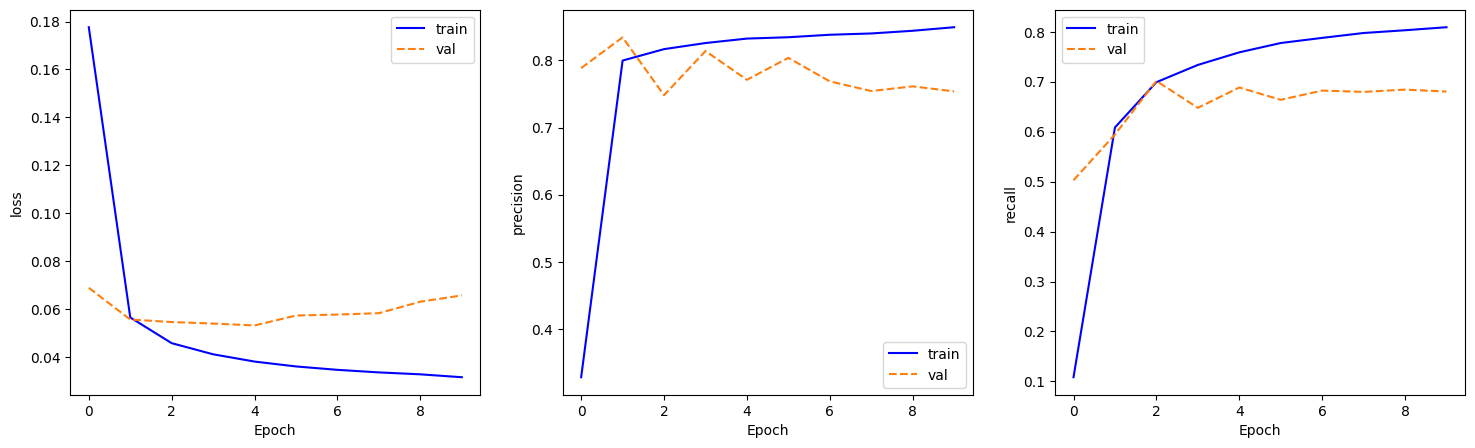

In [33]:
# Carrega o log de treinamento do modelo 3 no fold 0 (fold com melhor performance)
history = pd.read_csv('models/model_7/hist/train_log_0.csv')

# Plota as learning curvs do modelo
plot_history(history)

## Modelo 8 - RNN + Muita Limpeza + GloVe

No modelo abaixo iremos utilizar matrizes de embeddings pre-treinadas, começando por embeddings com dimensão igual a 25.

In [48]:
def get_model_8(vectorizer, Embedding):
    model = Sequential()
    model.add(Input(shape = (1,), dtype = tf.string))
    model.add(vectorizer)    
    model.add(Embedding)
    model.add(Bidirectional(LSTM(32, activation='tanh')))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(6, activation='sigmoid'))
    return model

n_folds = 4


METRICS = [AUC(name = 'auc'), 
           Precision(name = 'precision'), 
           Recall(name = 'recall')]  

output_sequence_length = 300


for i in range(n_folds):
    
    print('Treinando modelo no fold {}...'.format(i))
    
    # Carregando os dados tokenizados
    df_train = pd.read_pickle('dados/dados_limpos_5/train_tokenized_{}.pkl'.format(i))
    df_val = pd.read_pickle('dados/dados_limpos_5/val_tokenized_{}.pkl'.format(i))   
    
    # Cria o vetorizador de texto
    vocab = load_vocab('vocabulários/limpeza_5/vocabulary_{}.txt'.format(i))
    vectorizer = TextVectorization(output_mode = 'int', output_sequence_length = output_sequence_length, vocabulary = vocab)
    vocab_size = len(vectorizer.get_vocabulary())
    print('Tamanho do vocabulário do vetorizador fold {}: {}'.format(i, vocab_size))
    
    
    # Cria o Embedding
    weights = np.load("vocabulários/limpeza_5/weights_{}.npy".format(i))
    e = Embedding(vocab_size, 25, embeddings_initializer = tf.keras.initializers.Constant(weights), input_length=4, trainable=False)
    
    
    #Prepara os dados
    Xtrain = df_train.loc[:, 'comment_text'].values
    ytrain = df_train.loc[:, ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
    Xval = df_val.loc[:, 'comment_text'].values
    yval = df_val.loc[:, ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
    
    
    # Treina o modelo
    callbacks = [EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights = True), CSVLogger(filename = 'models/model_8/hist/train_log_{}.csv'.format(i))]
    model_8 = get_model_8(vectorizer, e)
    model_8.compile(optimizer = 'adam', loss = 'BinaryCrossentropy', metrics = METRICS)
    model_8.fit(Xtrain, ytrain, batch_size = 1024, epochs = 40, verbose = 0, validation_data = (Xval, yval), callbacks = callbacks)
    
    # Avalia o modelo
    print('Train score:')
    predictions = model_8.predict(Xtrain, verbose = 0)
    evaluate_model(predictions = predictions, y = ytrain, model_name = 'RNN + Muita Limpeza + GloVe')
    print('Val score:')
    predictions = model_8.predict(Xval, verbose = 0)
    if i == 0:
        result = evaluate_model(predictions = predictions, y = yval, model_name = 'RNN + Muita Limpeza + GloVe')
        results = result.copy()
    else:
        result = evaluate_model(predictions = predictions, y = yval, model_name = 'RNN + Muita Limpeza + GloVe')
        results.iloc[:,0:-1] = results.iloc[:,0:-1] + result.iloc[:,0:-1]
    print('\n')
        
results.iloc[:,0:-1] = results.iloc[:,0:-1]/n_folds 

Treinando modelo no fold 0...
Tamanho do vocabulário do vetorizador fold 0: 40943
Train score:
Model's ROC AUC: 0.988
Model's PR AUC: 0.844
Val score:
Model's ROC AUC: 0.984
Model's PR AUC: 0.814


Treinando modelo no fold 1...
Tamanho do vocabulário do vetorizador fold 1: 40991
Train score:
Model's ROC AUC: 0.989
Model's PR AUC: 0.846
Val score:
Model's ROC AUC: 0.984
Model's PR AUC: 0.809


Treinando modelo no fold 2...
Tamanho do vocabulário do vetorizador fold 2: 40955
Train score:
Model's ROC AUC: 0.989
Model's PR AUC: 0.853
Val score:
Model's ROC AUC: 0.983
Model's PR AUC: 0.803


Treinando modelo no fold 3...
Tamanho do vocabulário do vetorizador fold 3: 40950
Train score:
Model's ROC AUC: 0.988
Model's PR AUC: 0.836
Val score:
Model's ROC AUC: 0.983
Model's PR AUC: 0.802




In [30]:
# Salva o modelo
model_8.save('models/model_8/model')

INFO:tensorflow:Assets written to: models/model_8/model\assets


INFO:tensorflow:Assets written to: models/model_8/model\assets


In [31]:
# Salva os resultados da avaliação do modelo em um arquivo excel
model_performance_log(results)

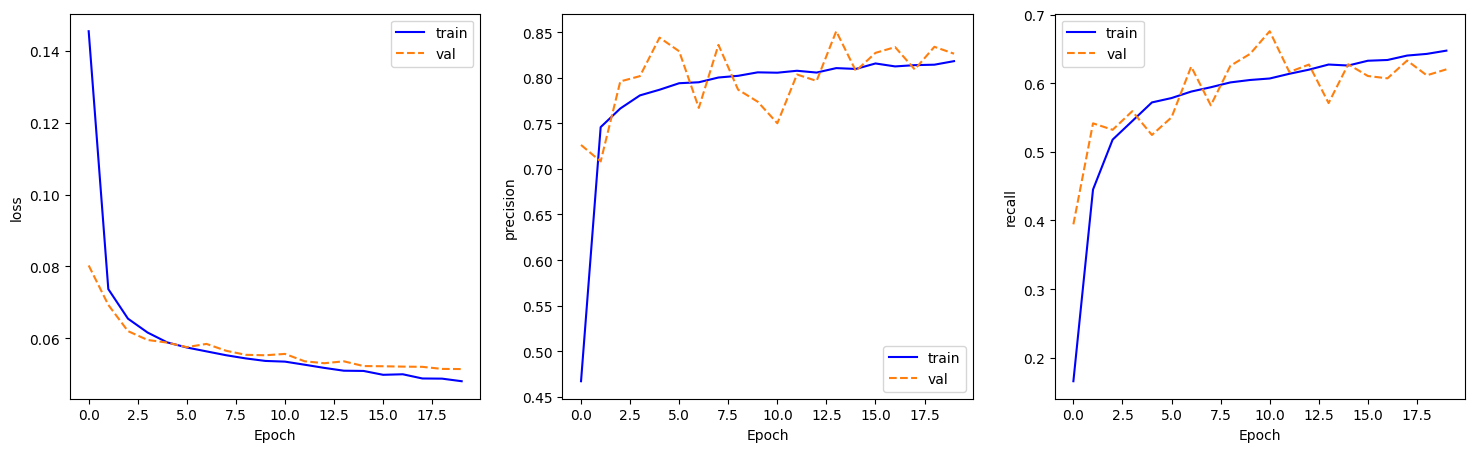

In [32]:
# Carrega o log de treinamento do modelo 3 no fold 0 (fold com melhor performance)
history = pd.read_csv('models/model_8/hist/train_log_0.csv')

# Plota as learning curvs do modelo
plot_history(history)

Observar que tivemos uma melhora significativa do modelo e das curvas de aprendizado.

## Modelo 9 - RNN + Muita Limpeza + GloVe + Lemma

No modelo a seguir além do embedding pre-treinado iremos também aplicar um algorítimo de lematização durante a limpeza dos dados.

In [41]:
def get_model_9(vectorizer, Embedding):
    model = Sequential()
    model.add(Input(shape = (1,), dtype = tf.string))
    model.add(vectorizer)    
    model.add(Embedding)
    model.add(Bidirectional(LSTM(32, activation='tanh')))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(6, activation='sigmoid'))
    return model

n_folds = 4


METRICS = [AUC(name = 'auc'), 
           Precision(name = 'precision'), 
           Recall(name = 'recall')]  

output_sequence_length = 300


for i in range(n_folds):
    
    print('Treinando modelo no fold {}...'.format(i))
    
    # Carregando os dados tokenizados
    df_train = pd.read_pickle('dados/dados_limpos_6/train_tokenized_{}.pkl'.format(i))
    df_val = pd.read_pickle('dados/dados_limpos_6/val_tokenized_{}.pkl'.format(i))   
    
    # Cria o vetorizador de texto
    vocab = load_vocab('vocabulários/limpeza_6/vocabulary_{}.txt'.format(i))
    vectorizer = TextVectorization(output_mode = 'int', output_sequence_length = output_sequence_length, vocabulary = vocab)
    vocab_size = len(vectorizer.get_vocabulary())
    print('Tamanho do vocabulário do vetorizador fold {}: {}'.format(i, vocab_size))
    
    
    # Cria o Embedding
    weights = np.load("vocabulários/limpeza_6/weights_{}.npy".format(i))
    e = Embedding(vocab_size, 25, embeddings_initializer = tf.keras.initializers.Constant(weights), input_length=4, trainable=False)
    
    
    #Prepara os dados
    Xtrain = df_train.loc[:, 'comment_text'].values
    ytrain = df_train.loc[:, ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
    Xval = df_val.loc[:, 'comment_text'].values
    yval = df_val.loc[:, ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
    
    
    # Treina o modelo
    callbacks = [EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights = True), CSVLogger(filename = 'models/model_9/hist/train_log_{}.csv'.format(i))]
    model_9 = get_model_9(vectorizer, e)
    model_9.compile(optimizer = 'adam', loss = 'BinaryCrossentropy', metrics = METRICS)
    model_9.fit(Xtrain, ytrain, batch_size = 1024, epochs = 40, verbose = 0, validation_data = (Xval, yval), callbacks = callbacks)
    
    # Avalia o modelo
    print('Train score:')
    predictions = model_9.predict(Xtrain, verbose = 0)
    evaluate_model(predictions = predictions, y = ytrain, model_name = 'RNN + Muita Limpeza + GloVe + Lemma')
    print('Val score:')
    predictions = model_9.predict(Xval, verbose = 0)
    if i == 0:
        result = evaluate_model(predictions = predictions, y = yval, model_name = 'RNN + Muita Limpeza + GloVe + Lemma')
        results = result.copy()
    else:
        result = evaluate_model(predictions = predictions, y = yval, model_name = 'RNN + Muita Limpeza + GloVe + Lemma')
        results.iloc[:,0:-1] = results.iloc[:,0:-1] + result.iloc[:,0:-1]
    print('\n')
        
results.iloc[:,0:-1] = results.iloc[:,0:-1]/n_folds 

Treinando modelo no fold 0...
Tamanho do vocabulário do vetorizador fold 0: 36393
Train score:
Model's ROC AUC: 0.988
Model's PR AUC: 0.842
Val score:
Model's ROC AUC: 0.982
Model's PR AUC: 0.808


Treinando modelo no fold 1...
Tamanho do vocabulário do vetorizador fold 1: 36388
Train score:
Model's ROC AUC: 0.987
Model's PR AUC: 0.833
Val score:
Model's ROC AUC: 0.983
Model's PR AUC: 0.801


Treinando modelo no fold 2...
Tamanho do vocabulário do vetorizador fold 2: 36372
Train score:
Model's ROC AUC: 0.989
Model's PR AUC: 0.853
Val score:
Model's ROC AUC: 0.984
Model's PR AUC: 0.811


Treinando modelo no fold 3...
Tamanho do vocabulário do vetorizador fold 3: 36378
Train score:
Model's ROC AUC: 0.987
Model's PR AUC: 0.834
Val score:
Model's ROC AUC: 0.983
Model's PR AUC: 0.802




In [42]:
# Salva o modelo
model_9.save('models/model_9/model')

INFO:tensorflow:Assets written to: models/model_9/model\assets


INFO:tensorflow:Assets written to: models/model_9/model\assets


In [43]:
# Salva os resultados da avaliação do modelo em um arquivo excel
model_performance_log(results)

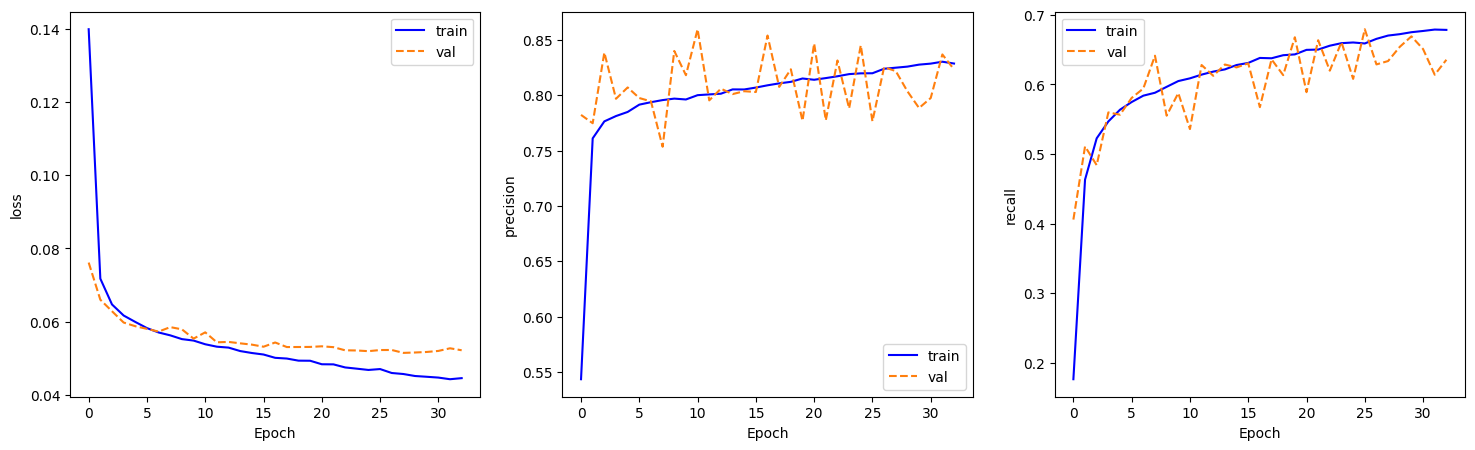

In [44]:
# Carrega o log de treinamento do modelo 3 no fold 0 (fold com melhor performance)
history = pd.read_csv('models/model_9/hist/train_log_0.csv')

# Plota as learning curvs do modelo
plot_history(history)

A aplicação do algorítimo de lematização não trouxe uma melhora significativa para o modelo, sendo assim iremos dispensar a utilização da mesma nas próximas etapas.

## Modelo 10 - RNN + Muita Limpeza + GloVe 50d 

Finalmente iremos treinar nosso último modelo, agora com embeddings com dimensão igual a 50. Observar que para este modelo iremos treinar apenas dois folds devido a demanda computacional para rodar este modelo.

In [29]:
def get_model_10(vectorizer, Embedding):
    model = Sequential()
    model.add(Input(shape = (1,), dtype = tf.string))
    model.add(vectorizer)    
    model.add(Embedding)
    model.add(Bidirectional(LSTM(32, activation='tanh')))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(6, activation='sigmoid'))
    return model

n_folds = 2


METRICS = [AUC(name = 'auc'), 
           Precision(name = 'precision'), 
           Recall(name = 'recall')]  

output_sequence_length = 300


for i in range(n_folds):
    
    print('Treinando modelo no fold {}...'.format(i))
    
    # Carregando os dados tokenizados
    df_train = pd.read_pickle('dados/dados_limpos_7/train_tokenized_{}.pkl'.format(i))
    df_val = pd.read_pickle('dados/dados_limpos_7/val_tokenized_{}.pkl'.format(i))   
    
    # Cria o vetorizador de texto
    vocab = load_vocab('vocabulários/limpeza_7/vocabulary_{}.txt'.format(i))
    vectorizer = TextVectorization(output_mode = 'int', output_sequence_length = output_sequence_length, vocabulary = vocab)
    vocab_size = len(vectorizer.get_vocabulary())
    print('Tamanho do vocabulário do vetorizador fold {}: {}'.format(i, vocab_size))
    
    
    # Cria o Embedding
    weights = np.load("vocabulários/limpeza_7/weights_{}.npy".format(i))
    e = Embedding(vocab_size, 50, embeddings_initializer = tf.keras.initializers.Constant(weights), input_length=output_sequence_length, trainable=False)
    
    
    #Prepara os dados
    Xtrain = df_train.loc[:, 'comment_text'].values
    ytrain = df_train.loc[:, ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
    Xval = df_val.loc[:, 'comment_text'].values
    yval = df_val.loc[:, ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
    
    
    # Treina o modelo
    callbacks = [EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights = True), CSVLogger(filename = 'models/model_10/hist/train_log_{}.csv'.format(i))]
    model_10 = get_model_10(vectorizer, e)
    model_10.compile(optimizer = 'adam', loss = 'BinaryCrossentropy', metrics = METRICS)
    model_10.fit(Xtrain, ytrain, batch_size = 1024, epochs = 40, verbose = 0, validation_data = (Xval, yval), callbacks = callbacks)
    
    # Avalia o modelo
    print('Train score:')
    predictions = model_10.predict(Xtrain, verbose = 0)
    evaluate_model(predictions = predictions, y = ytrain, model_name = 'RNN + Muita Limpeza + GloVe 50d')
    print('Val score:')
    predictions = model_10.predict(Xval, verbose = 0)
    if i == 0:
        result = evaluate_model(predictions = predictions, y = yval, model_name = 'RNN + Muita Limpeza + GloVe 50d')
        results = result.copy()
    else:
        result = evaluate_model(predictions = predictions, y = yval, model_name = 'RNN + Muita Limpeza + GloVe 50d')
        results.iloc[:,0:-1] = results.iloc[:,0:-1] + result.iloc[:,0:-1]
    print('\n')
        
results.iloc[:,0:-1] = results.iloc[:,0:-1]/n_folds 

Treinando modelo no fold 0...
Tamanho do vocabulário do vetorizador fold 0: 40943
Train score:
Model's ROC AUC: 0.99
Model's PR AUC: 0.862
Val score:
Model's ROC AUC: 0.986
Model's PR AUC: 0.828


Treinando modelo no fold 1...
Tamanho do vocabulário do vetorizador fold 1: 40991
Train score:
Model's ROC AUC: 0.99
Model's PR AUC: 0.854
Val score:
Model's ROC AUC: 0.986
Model's PR AUC: 0.825




In [27]:
# Salva o modelo
model_10.save('models/model_10/model')

INFO:tensorflow:Assets written to: models/model_10/model\assets


INFO:tensorflow:Assets written to: models/model_10/model\assets


In [28]:
# Salva os resultados da avaliação do modelo em um arquivo excel
model_performance_log(results)

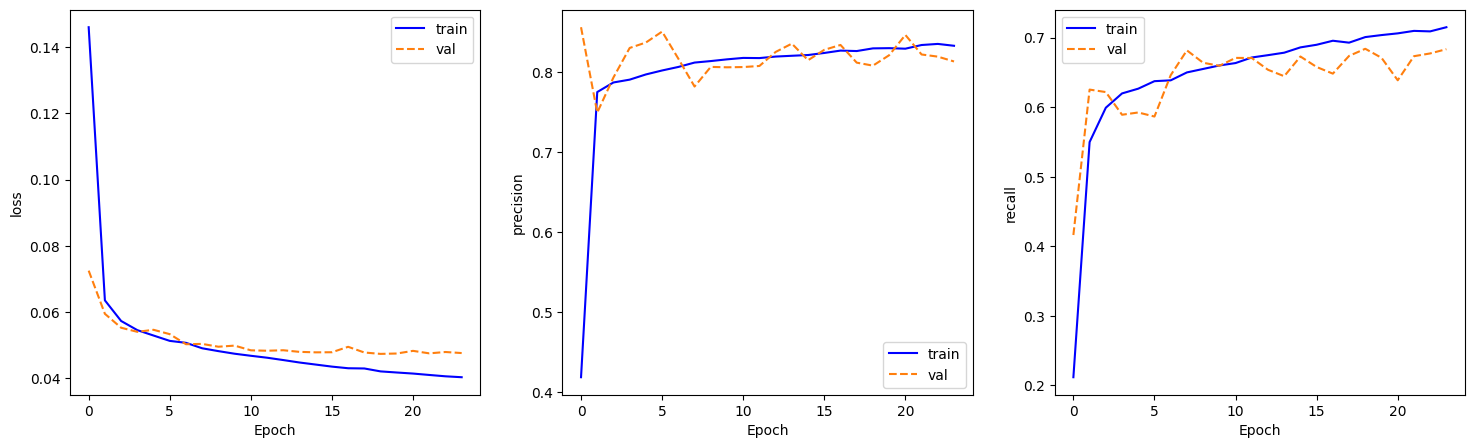

In [163]:
# Carrega o log de treinamento do modelo 10 no fold 0 (fold com melhor performance)
history = pd.read_csv('models/model_10/hist/train_log_0.csv')

# Plota as learning curvs do modelo
plot_history(history)

Observando os resultados, claramente obtivemos uma melhora do modelo o que indica que a utilização de embeddings maiores trará melhor desempenho ao modelo. Na próxima seção iremos buscar uma melhora maior ainda nos resultados através da busca por melhores hyperparâmetros para os modelos.

# Hyperparameter Tuning

Antes de realizarmos a busca dos hiperparâmetros do modelo irei apresentar a comparação de todas as métricas medidas para os modelos que foram treinados na seção anterior.

In [70]:
# Métricas de todos os modelos (versão resumida)
results = pd.read_excel('model_performance_log.xlsx', index_col = 0)
results.loc['PR_AUC'].head(10)

,toxic,severe_toxic,obscene,threat,insult,identity_hate,total,model_name
PR_AUC,0.82375,0.40775,0.82975,0.28800,0.73000,0.41250,0.77425,MLP + Limpeza
PR_AUC,0.76825,0.27725,0.71675,0.05025,0.65775,0.12000,0.69125,CNN + Limpeza
PR_AUC,0.83625,0.44825,0.83375,0.05900,0.74000,0.15875,0.77975,RNN + Limpeza
PR_AUC,0.80525,0.36100,0.81025,0.06550,0.67975,0.14075,0.74775,MultiCNN + Limpeza
PR_AUC,0.80150,0.43950,0.79650,0.06175,0.69625,0.14825,0.74200,RNN + S/Limpeza
PR_AUC,0.84850,0.45950,0.83900,0.05825,0.74575,0.14800,0.78925,RNN + Muita Limpeza
PR_AUC,0.85100,0.45650,0.84700,0.05775,0.75425,0.15575,0.79300,RNN + Muita Limpeza + Vocab
PR_AUC,0.85150,0.46900,0.85450,0.13025,0.76675,0.35800,0.80125,RNN + Muita Limpeza + GloVe
PR_AUC,0.85325,0.47600,0.85350,0.20775,0.77175,0.39000,0.80550,RNN + Muita Limpeza + GloVe + Lemma
PR_AUC,0.87400,0.48750,0.88250,0.20950,0.78900,0.40400,0.82850,RNN + Muita Limpeza + GloVe 50d


In [69]:
# Métricas de todos os modelos (versão completa)
results = pd.read_excel('model_performance_log.xlsx', index_col = 0)
results.head(50)

,toxic,severe_toxic,obscene,threat,insult,identity_hate,total,model_name
Precision,0.86450,0.50750,0.87025,0.69175,0.77825,0.67275,0.83350,MLP + Limpeza
recall_score,0.66850,0.21000,0.68500,0.05175,0.57975,0.19850,0.60425,MLP + Limpeza
f1_score,0.75375,0.29675,0.76675,0.09575,0.66450,0.30475,0.70100,MLP + Limpeza
ROC_AUC,0.95175,0.97200,0.96900,0.89925,0.96325,0.93150,0.96750,MLP + Limpeza
PR_AUC,0.82375,0.40775,0.82975,0.28800,0.73000,0.41250,0.77425,MLP + Limpeza
Precision,0.82550,0.44075,0.75375,0.00000,0.71450,0.12500,0.77450,CNN + Limpeza
recall_score,0.60850,0.02125,0.64175,0.00000,0.55875,0.00100,0.54650,CNN + Limpeza
f1_score,0.69825,0.03775,0.69200,0.00000,0.62250,0.00175,0.63900,CNN + Limpeza
ROC_AUC,0.93950,0.97175,0.95725,0.93400,0.95775,0.90025,0.95875,CNN + Limpeza
PR_AUC,0.76825,0.27725,0.71675,0.05025,0.65775,0.12000,0.69125,CNN + Limpeza


Para a busca de hyperparametros podemos utilizar duas abordagens, uma seria utilizarmos as funções presentes na biblioteca sklearn e a segunda seria aplicarmos as funções diponiveis na biblioteca keras_tunner. Dentro destas duas abordagens a segunda opção sem dúvida é mais simples e direta, contudo para fique o registro da forma como podemos fazer a busca por hyperparâmetros utilizando o Sklearn mantive a seção abaixo. 

## Sklearn hyperparameter tunning

Os resultados da busca segundo o código abaixo serão salvos em um arquivo chamado results.pkl

In [26]:
# Carrega todos os dados em um data frame
df = pd.read_csv('dados/train.csv/train.csv')

# Carrega o Word Embedding
embedding_dict = dict()
file = open('word_embedding/GloVe/glove.twitter.27B.50d.txt', encoding = 'utf-8')
for line in file:
    values = line.split()
    words = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_dict[words] = coefs  
file.close()

# Limpa e tokeniza o texto
df['comment_text'] = df['comment_text'].apply(clean_text_3)

# Cria uma coluna com o index de cada linha
df['idx'] = np.array(df.index)

# Reparte os dados em conjuntos de treino e validação e salva em disco os dados
df_train, df_val = train_test_split(df, test_size = 0.2, random_state = 0)

# Criando o vocabulário
counter = Counter()
for list_of_tokens in df_train['comment_text']:
    create_vocab(list_of_tokens, counter)
        
# Exclui as palavras com menor frquência do vocabulário
vocab = [word for word, frequency in counter.items() if frequency > 2]
    
# Cria a matrix de embbeding e o word index
embedding_matrix = np.zeros((2,50))
word_index = []
for word in vocab:
    weight = embedding_dict.get(word, None)
    if weight is not None:        
        weight = np.expand_dims(weight, axis = 0)
        embedding_matrix = np.concatenate([embedding_matrix, weight])
        word_index.append(word)
np.save('vocabulários/hypopt/weights.npy', embedding_matrix, allow_pickle=False)

# Exibe o tamanho final do vocabulário
print('Tamanho do Vocabulário: {}'.format(len(word_index)))
    
# Salva o vocabulário
save_list(word_index, 'vocabulários/hypopt/vocabulary.txt')

# Filtra os arquivos de texto para que só tenham palavras do vocabulário
df_train['comment_text'] = df_train['comment_text'].apply(process_text, vocab = word_index)
df_val['comment_text'] = df_val['comment_text'].apply(process_text, vocab = word_index)

# Filtra os arquivos de texto para que só tenham palavras do vocabulário
df_train['comment_text'] = df_train['comment_text'].apply(process_text, vocab = word_index)
df_val['comment_text'] = df_val['comment_text'].apply(process_text, vocab = word_index)

# Une os tokens de cada texto em uma única string
df_train['comment_text'] = df_train['comment_text'].apply(join_string)
df_val['comment_text'] = df_val['comment_text'].apply(join_string)

# Cria uma coluna com a indicação dos dados de treino e teste que será utilizada para definirmos o mesmo split durante a escolha dos hiperparametros
df_train['predefined_stratification'] = -1
df_val['predefined_stratification'] = 0

# Junta os dados de treino e validação
df_final = pd.concat([df_train, df_val], axis = 0)

# Ordena os dados pela coluna idx
df_final = df_final.sort_values(by = 'idx')

# Salva os dados processados no disco
df_final.to_pickle('dados/dados_hypopt/df_final.pkl')

def create_rnn_model(lstm_neurons, dp_rate, dense_1_neurons, dense_2_neurons, dense_3_neurons, vocab_size = 40878):
    
    weights = np.load("vocabulários/hypopt/weights.npy")
    e = Embedding(vocab_size, 50, embeddings_initializer = tf.keras.initializers.Constant(weights), input_length=4, trainable=False)
    
    model = Sequential()
    model.add(Input(shape = (300,)))
    model.add(e)
    model.add(Bidirectional(LSTM(lstm_neurons, activation='tanh')))
    model.add(Dropout(dp_rate))
    model.add(Dense(dense_1_neurons, activation='relu'))
    model.add(Dropout(dp_rate))
    model.add(Dense(dense_2_neurons, activation='relu'))
    model.add(Dropout(dp_rate))
    model.add(Dense(dense_3_neurons, activation='relu'))
    model.add(Dense(6, activation='sigmoid'))
    
    model.compile(optimizer = 'adam', loss = 'BinaryCrossentropy', metrics = ['accuracy'])

    return model

# Carrega os dados
df_final = pd.read_pickle('dados/dados_hypopt/df_final.pkl')

# Cria o test_fold para que possamos sempre fazer a mesma divisão de dados
test_fold = df_final.pop('predefined_stratification')

# Separa X e y
X = df_final.loc[:, 'comment_text'].values
y = df_final.loc[:, ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

# Tokeniza o texto
vocab = load_vocab('vocabulários/hypopt/vocabulary.txt')
vectorizer = TextVectorization(output_mode = 'int', output_sequence_length = 300, vocabulary = vocab)
vocab_size = len(vectorizer.get_vocabulary())
X = vectorizer(X).numpy()

# Cria a grade de parametros onde iremos buscar os melhores ajustes
lstm_neurons = [16, 32, 64] 
dp_rate = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
dense_1_neurons = [128, 256] 
dense_2_neurons = [128, 256]
dense_3_neurons = [128, 256]
param_grid = dict(model__lstm_neurons=lstm_neurons, 
                  model__dp_rate=dp_rate, 
                  model__dense_1_neurons=dense_1_neurons, 
                  model__dense_2_neurons=dense_2_neurons, 
                  model__dense_3_neurons=dense_3_neurons)

model = KerasClassifier(model=create_rnn_model, vocab_size = vocab_size, batch_size = 500, epochs = 20)

# Realiza a busca dos melhores parametros
ps = PredefinedSplit(test_fold)
random_search = RandomizedSearchCV(estimator = model, n_iter = 10, cv = ps, param_distributions = param_grid, scoring = 'roc_auc')
search = random_search.fit(X, y)

# Salva os resultados
results = pd.DataFrame(search.cv_results_)
results.to_pickle('results.pkl')

Epoch 1/20
256/256 [==============================] - 13s 39ms/step - loss: 0.1052 - accuracy: 0.9331
Epoch 2/20
256/256 [==============================] - 10s 39ms/step - loss: 0.0599 - accuracy: 0.9931
Epoch 3/20
256/256 [==============================] - 10s 38ms/step - loss: 0.0554 - accuracy: 0.9937
Epoch 4/20
256/256 [==============================] - 10s 38ms/step - loss: 0.0534 - accuracy: 0.9930
Epoch 5/20
256/256 [==============================] - 10s 38ms/step - loss: 0.0520 - accuracy: 0.9937
Epoch 6/20
256/256 [==============================] - 10s 38ms/step - loss: 0.0508 - accuracy: 0.9931
Epoch 7/20
256/256 [==============================] - 10s 38ms/step - loss: 0.0495 - accuracy: 0.9930
Epoch 8/20
256/256 [==============================] - 10s 38ms/step - loss: 0.0488 - accuracy: 0.9935
Epoch 9/20
256/256 [==============================] - 10s 38ms/step - loss: 0.0480 - accuracy: 0.9919
Epoch 10/20
256/256 [==============================] - 10s 38ms/step - loss: 0.047

## Keras hyperparameter tunning

Na seção abaixo iremos fazer a busca porr hyperparametros utilizando o keras_tunner. Ao final da busca iremos treinar o modelo com os melhores hyperparametros encontrados.

In [27]:
def rnn_model(hp):
    
    # Cria o vetorizador de texto
    vocab = load_vocab('vocabulários/limpeza_7/vocabulary_{}.txt'.format(0))
    vectorizer = TextVectorization(output_mode = 'int', output_sequence_length = 300, vocabulary = vocab)
    vocab_size = len(vectorizer.get_vocabulary())

    # Cria o Embedding
    weights = np.load("vocabulários/limpeza_7/weights_{}.npy".format(0))
    e = Embedding(vocab_size, 50, embeddings_initializer = tf.keras.initializers.Constant(weights), input_length=300, trainable=False)
    
    model = Sequential()
    model.add(Input(shape = (1,), dtype = tf.string))
    model.add(vectorizer)    
    model.add(e)
    
    hp_lstm = hp.Int('units', min_value=16, max_value=64, step=2)
    model.add(Bidirectional(LSTM(hp_lstm, activation='tanh')))
    
    hp_dropout = hp.Float('dropout', min_value=0, max_value=0.9, step=0.1)
    
    hp_dense_1 = hp.Choice('Dense_1', [64, 128, 256])
    model.add(Dropout(hp_dropout))
    model.add(Dense(hp_dense_1, activation='relu'))
    
    hp_dense_2 = hp.Choice('Dense_2', [64, 128, 256])
    model.add(Dropout(hp_dropout))
    model.add(Dense(hp_dense_2, activation='relu'))
    
    hp_dense_3 = hp.Choice('Dense_3', [64, 128, 256])
    model.add(Dropout(hp_dropout))
    model.add(Dense(hp_dense_3, activation='relu'))
    
    model.add(Dense(6, activation='sigmoid'))
    
    model.compile(optimizer = 'adam', loss = 'BinaryCrossentropy', metrics = ['BinaryCrossentropy'])
    
    return model

    
tuner = kt.RandomSearch(
    hypermodel=rnn_model,
    objective="val_loss",
    max_trials=20,
    executions_per_trial=2,
    overwrite=True,
    directory="models",
    project_name="rnn_tuning",
)

# Carregando os dados tokenizados
df_train = pd.read_pickle('dados/dados_limpos_7/train_tokenized_{}.pkl'.format(0))
df_train = df_train.sample(frac = 0.5)
df_val = pd.read_pickle('dados/dados_limpos_7/val_tokenized_{}.pkl'.format(0)) 
df_val = df_val.sample(frac = 0.5)

#Prepara os dados
Xtrain = df_train.loc[:, 'comment_text'].values
ytrain = df_train.loc[:, ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
Xval = df_val.loc[:, 'comment_text'].values
yval = df_val.loc[:, ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values    
    
# Treina o modelo
callbacks = [EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights = True)]
tuner.search(Xtrain, ytrain, batch_size = 500, epochs = 40, validation_data = (Xval, yval), callbacks = callbacks)

Trial 20 Complete [00h 10m 59s]
val_loss: 0.049434226006269455

Best val_loss So Far: 0.04935275390744209
Total elapsed time: 04h 29m 21s
INFO:tensorflow:Oracle triggered exit


In [55]:
# Exibe os 3 melhores resultados obtidos na busca
tuner.results_summary(3)

Results summary
Results in models\rnn_tuning
Showing 3 best trials
Trial summary
Hyperparameters:
units: 54
dropout: 0.1
Dense_1: 256
Dense_2: 64
Dense_3: 256
Score: 0.04935275390744209
Trial summary
Hyperparameters:
units: 36
dropout: 0.30000000000000004
Dense_1: 256
Dense_2: 128
Dense_3: 128
Score: 0.049434226006269455
Trial summary
Hyperparameters:
units: 62
dropout: 0.4
Dense_1: 128
Dense_2: 256
Dense_3: 64
Score: 0.04970475286245346


In [51]:
# Exibe os hyperparametros do melhor modelo treinado
hiper = tuner.get_best_hyperparameters(1)
hiper[0].values

{'units': 54, 'dropout': 0.1, 'Dense_1': 256, 'Dense_2': 64, 'Dense_3': 256}

Abaixo faremos o treinamento e validação do modelo com os melhores hyperparâmetros.

In [26]:
def get_rnn(vectorizer, Embedding):
    model = Sequential()
    model.add(Input(shape = (1,), dtype = tf.string))
    
    model.add(vectorizer) 
    
    model.add(Embedding)
    
    model.add(Bidirectional(LSTM(54, activation='tanh')))
    
    model.add(Dropout(0.1))
    model.add(Dense(256, activation='relu'))
    
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='relu'))
    
    model.add(Dropout(0.1))
    model.add(Dense(256, activation='relu'))
    
    model.add(Dense(6, activation='sigmoid'))
    return model

n_folds = 2


METRICS = [AUC(name = 'auc'), 
           Precision(name = 'precision'), 
           Recall(name = 'recall')]  

output_sequence_length = 300


for i in range(n_folds):
    
    print('Treinando modelo no fold {}...'.format(i))
    
    # Carregando os dados tokenizados
    df_train = pd.read_pickle('dados/dados_limpos_7/train_tokenized_{}.pkl'.format(i))
    df_val = pd.read_pickle('dados/dados_limpos_7/val_tokenized_{}.pkl'.format(i))   
    
    # Cria o vetorizador de texto
    vocab = load_vocab('vocabulários/limpeza_7/vocabulary_{}.txt'.format(i))
    vectorizer = TextVectorization(output_mode = 'int', output_sequence_length = output_sequence_length, vocabulary = vocab)
    vocab_size = len(vectorizer.get_vocabulary())
    print('Tamanho do vocabulário do vetorizador fold {}: {}'.format(i, vocab_size))
    
    
    # Cria o Embedding
    weights = np.load("vocabulários/limpeza_7/weights_{}.npy".format(i))
    e = Embedding(vocab_size, 50, embeddings_initializer = tf.keras.initializers.Constant(weights), input_length=output_sequence_length, trainable=True)
    
    
    #Prepara os dados
    Xtrain = df_train.loc[:, 'comment_text'].values
    ytrain = df_train.loc[:, ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
    Xval = df_val.loc[:, 'comment_text'].values
    yval = df_val.loc[:, ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
    
    
    # Treina o modelo
    callbacks = [EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights = True), 
                 CSVLogger(filename = 'models/rnn_model/hist/train_log_{}.csv'.format(i)),
                 TensorBoard(log_dir='models/rnn_model/tb_{}'.format(i), histogram_freq=1)]
    
    rnn_model = get_rnn(vectorizer, e)
    rnn_model.compile(optimizer = 'adam', loss = 'BinaryCrossentropy', metrics = METRICS)
    rnn_model.fit(Xtrain, ytrain, batch_size = 1024, epochs = 40, verbose = 0, validation_data = (Xval, yval), callbacks = callbacks)
    
    # Avalia o modelo
    print('Train score:')
    predictions = rnn_model.predict(Xtrain, verbose = 0)
    evaluate_model(predictions = predictions, y = ytrain, model_name = 'Tuned RNN + Muita Limpeza + GloVe 50d')
    print('Val score:')
    predictions = rnn_model.predict(Xval, verbose = 0)
    if i == 0:
        result = evaluate_model(predictions = predictions, y = yval, model_name = 'Tuned RNN + Muita Limpeza + GloVe 50d')
        results = result.copy()
    else:
        result = evaluate_model(predictions = predictions, y = yval, model_name = 'Tuned RNN + Muita Limpeza + GloVe 50d')
        results.iloc[:,0:-1] = results.iloc[:,0:-1] + result.iloc[:,0:-1]
    print('\n')
        
results.iloc[:,0:-1] = results.iloc[:,0:-1]/n_folds 

Treinando modelo no fold 0...
Tamanho do vocabulário do vetorizador fold 0: 40943
Train score:
Model's ROC AUC: 0.992
Model's PR AUC: 0.879
Val score:
Model's ROC AUC: 0.987
Model's PR AUC: 0.839


Treinando modelo no fold 1...
Tamanho do vocabulário do vetorizador fold 1: 40991
Train score:
Model's ROC AUC: 0.992
Model's PR AUC: 0.874
Val score:
Model's ROC AUC: 0.988
Model's PR AUC: 0.838




In [27]:
# Salva o modelo
rnn_model.save('models/rnn_model/model')

INFO:tensorflow:Assets written to: models/rnn_model/model\assets


INFO:tensorflow:Assets written to: models/rnn_model/model\assets


In [28]:
# Salva os resultados da avaliação do modelo em um arquivo excel
model_performance_log(results)

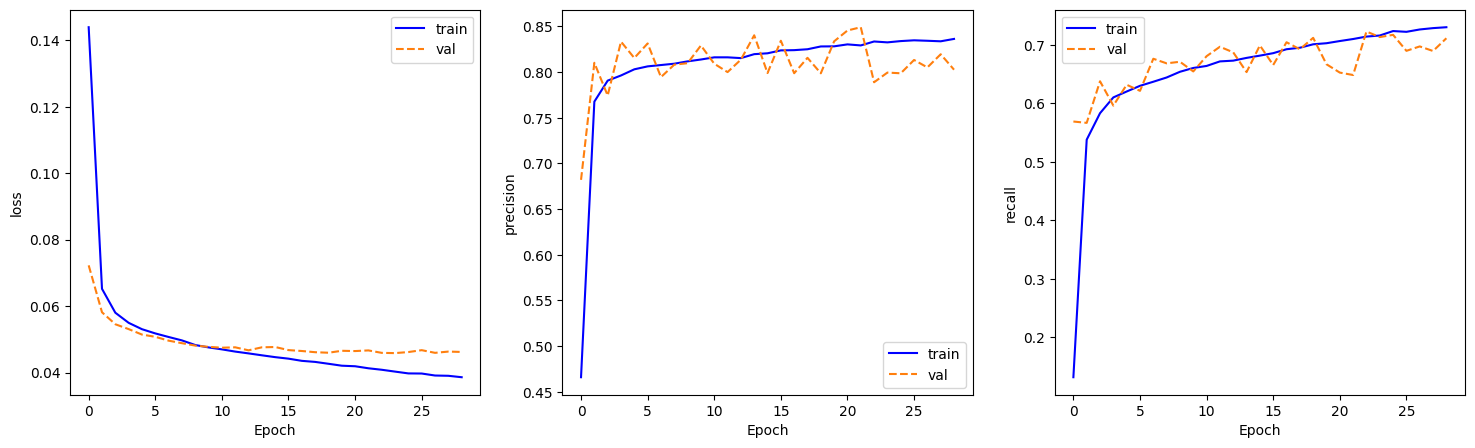

In [29]:
# Carrega o log de treinamento do modelo 10 no fold 0 (fold com melhor performance)
history = pd.read_csv('models/rnn_model/hist/train_log_0.csv')

# Plota as learning curvs do modelo
plot_history(history)

Os resultados obtidos com o modelo acima superam todos os modelo que foram treinados até aqui, contudo sabemos que a aplicação de embeddings com maiores dimensões tendem a trazer resultados melhores, sendo assim faremos o treinamento do modelo acima com embeddings de dimensão igual a 100.

In [49]:
def get_rnn(vectorizer, Embedding):
    model = Sequential()
    model.add(Input(shape = (1,), dtype = tf.string))
    
    model.add(vectorizer) 
    
    model.add(Embedding)
    
    model.add(Bidirectional(LSTM(54, activation='tanh')))
    
    model.add(Dropout(0.1))
    model.add(Dense(256, activation='relu'))
    
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='relu'))
    
    model.add(Dropout(0.1))
    model.add(Dense(256, activation='relu'))
    
    model.add(Dense(6, activation='sigmoid'))
    return model

n_folds = 2


METRICS = [AUC(name = 'auc'), 
           Precision(name = 'precision'), 
           Recall(name = 'recall')]  

output_sequence_length = 300


for i in range(n_folds):
    
    print('Treinando modelo no fold {}...'.format(i))
    
    # Carregando os dados tokenizados
    df_train = pd.read_pickle('dados/dados_limpos_8/train_tokenized_{}.pkl'.format(i))   
    df_val = pd.read_pickle('dados/dados_limpos_8/val_tokenized_{}.pkl'.format(i))   

    
    
    # Cria o vetorizador de texto
    vocab = load_vocab('vocabulários/limpeza_8/vocabulary_{}.txt'.format(i))
    vectorizer = TextVectorization(output_mode = 'int', output_sequence_length = output_sequence_length, vocabulary = vocab)
    vocab_size = len(vectorizer.get_vocabulary())
    print('Tamanho do vocabulário do vetorizador fold {}: {}'.format(i, vocab_size))
    
    
    # Cria o Embedding
    weights = np.load("vocabulários/limpeza_8/weights_{}.npy".format(i))
    e = Embedding(vocab_size, 100, embeddings_initializer = tf.keras.initializers.Constant(weights), input_length=output_sequence_length, trainable=False)
    
    
    #Prepara os dados
    Xtrain = df_train.loc[:, 'comment_text'].values
    ytrain = df_train.loc[:, ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
    Xval = df_val.loc[:, 'comment_text'].values
    yval = df_val.loc[:, ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
    
    
    # Treina o modelo
    callbacks = [EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights = True), 
                 CSVLogger(filename = 'models/rnn_model/hist/train_log_{}.csv'.format(i)),
                 TensorBoard(log_dir='models/rnn_model/tb_{}'.format(i), histogram_freq=1)]
    
    rnn_model = get_rnn(vectorizer, e)
    rnn_model.compile(optimizer = 'adam', loss = 'BinaryCrossentropy', metrics = METRICS)
    rnn_model.fit(Xtrain, ytrain, batch_size = 500, epochs = 40, verbose = 0, validation_data = (Xval, yval), callbacks = callbacks)
    
    # Avalia o modelo
    print('Train score:')
    predictions = rnn_model.predict(Xtrain, verbose = 0)
    evaluate_model(predictions = predictions, y = ytrain, model_name = 'Tuned RNN + Muita Limpeza + GloVe 100d')
    print('Val score:')
    predictions = rnn_model.predict(Xval, verbose = 0)
    if i == 0:
        result = evaluate_model(predictions = predictions, y = yval, model_name = 'Tuned RNN + Muita Limpeza + GloVe 100d')
        results = result.copy()
    else:
        result = evaluate_model(predictions = predictions, y = yval, model_name = 'Tuned RNN + Muita Limpeza + GloVe 100d')
        results.iloc[:,0:-1] = results.iloc[:,0:-1] + result.iloc[:,0:-1]
    print('\n')
        
results.iloc[:,0:-1] = results.iloc[:,0:-1]/n_folds 

Treinando modelo no fold 0...
Tamanho do vocabulário do vetorizador fold 0: 40943
Train score:
Model's ROC AUC: 0.993
Model's PR AUC: 0.881
Val score:
Model's ROC AUC: 0.988
Model's PR AUC: 0.845


Treinando modelo no fold 1...
Tamanho do vocabulário do vetorizador fold 1: 40991
Train score:
Model's ROC AUC: 0.992
Model's PR AUC: 0.874
Val score:
Model's ROC AUC: 0.989
Model's PR AUC: 0.847




In [51]:
# Salva o modelo
rnn_model.save('models/rnn_model/model')

INFO:tensorflow:Assets written to: models/rnn_model/model\assets


INFO:tensorflow:Assets written to: models/rnn_model/model\assets


In [52]:
# Salva os resultados da avaliação do modelo em um arquivo excel
model_performance_log(results)

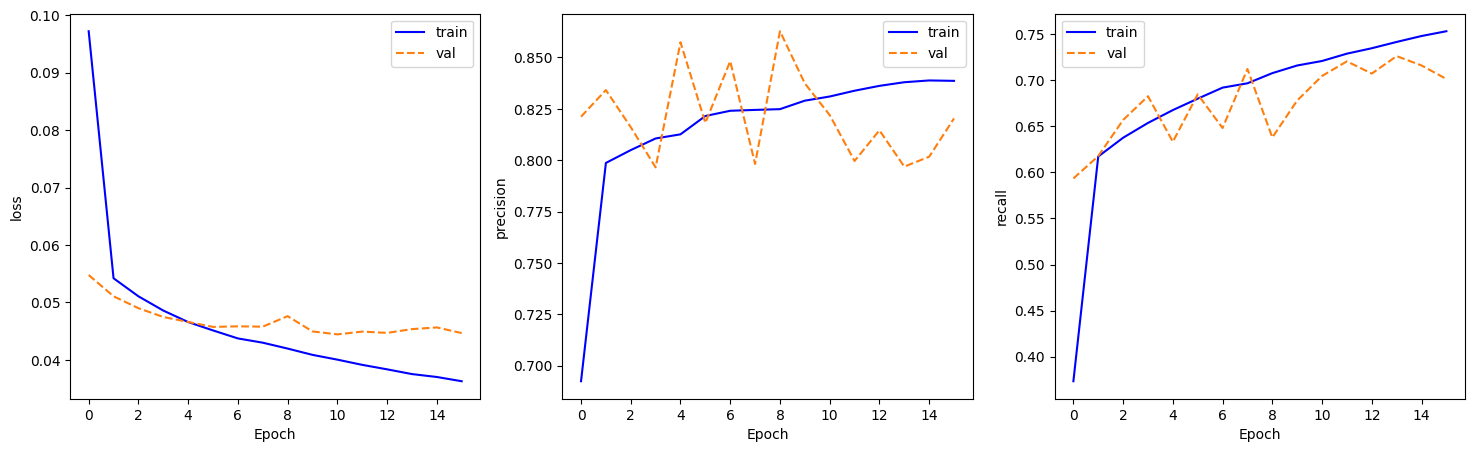

In [50]:
# Carrega o log de treinamento do modelo 10 no fold 0 (fold com melhor performance)
history = pd.read_csv('models/rnn_model/hist/train_log_0.csv')

# Plota as learning curvs do modelo
plot_history(history)

De fato o resultado deste modelo ficou superior com o aumento do embedding. Vamos agora treinar o modelo em todo o conjunto de treino e avalia-lo no conjunto de testes.

# Avaliação Final do Modelo

Para a avaliação final do modelo vamos utilizar o conjunto de teste que foi disponibilizado na plataforma kaggle, contudo teremos que tomar algumas medidas para avaliação do nosso modelo. Nas pagáinas da plataforma kaggle muito foi discutido sobre o fato da distribuição dos dados de teste não ser a mesma distribuição dos dados de treino resultando em uma performance do modelo muito abaixo do esperado. Sendo assim para sermos justos iremos misturar os dados de treino e teste e faremos novamente a divisão dos dados, mantendo lógico a mesma proporção que foi proposta originalmente. O modelo será novamente treinado no conjunto de treino de forma a não termos vazamento de informações do conjunto de testes para o conjunto de treino.

In [38]:
# Carrega os dados de treino em um data frame 
df_train = pd.read_csv('dados/train.csv/train.csv')

# Carregando os dados de teste
df_test_y = pd.read_csv('dados/test_labels.csv/test_labels.csv')
df_test_x = pd.read_csv('dados/test.csv/test.csv')

# Removendo as observações do conjunto de teste para as quais não temos os rótulos reais
mask = (df_test_y['toxic'] != -1)
df_test_y = df_test_y[mask].copy()
df_test_x = df_test_x[mask].copy()
df_test = pd.concat([df_test_x, df_test_y.iloc[:,1:]], axis = 1)

# Juntando os dados de treino e teste e redividindo
df = pd.concat([df_train, df_test], axis = 0)
df_train, df_test = train_test_split(df, test_size = 0.28, random_state = 0)    

# Carregando o Word Embedding
embedding_dict = dict()
file = open('word_embedding/GloVe/glove.twitter.27B.100d.txt', encoding = 'utf-8')
for line in file:
    values = line.split()
    words = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_dict[words] = coefs  
file.close()
        
print('Processando os dados...')
    
# Limpa e tokeniza o texto
df_train['comment_text'] = df_train['comment_text'].apply(clean_text_3)
print('Limpeza do conjunto de treino concluída.')

df_test['comment_text'] = df_test['comment_text'].apply(clean_text_3)
print('Limpeza do conjunto de teste concluída.')


print('Criando o vocabulário...')
# Criando o vocabulário
counter = Counter()
for list_of_tokens in df_train['comment_text']:
    create_vocab(list_of_tokens, counter)
        
# Exclui as palavras com menor frquência do vocabulário
vocab = [word for word, frequency in counter.items() if frequency > 2]
    
# Cria a matrix de embbeding e o word index
embedding_matrix = np.zeros((2,100))
word_index = []
for word in vocab:
    weight = embedding_dict.get(word, None)
    if weight is not None:        
        weight = np.expand_dims(weight, axis = 0)
        embedding_matrix = np.concatenate([embedding_matrix, weight])
        word_index.append(word)
    np.save('vocabulários/dados_finais/weights.npy', embedding_matrix, allow_pickle=False)
             
# Exibe o tamanho final do vocabulário
print('Tamanho do Vocabulário: {}'.format(len(word_index)))
    
# Salva o vocabulário
save_list(word_index, 'vocabulários/dados_finais/vocabulary.txt')
    
# Filtra os arquivos de texto para que só tenham palavras do vocabulário
df_train['comment_text'] = df_train['comment_text'].apply(process_text, vocab = word_index)
df_test['comment_text'] = df_test['comment_text'].apply(process_text, vocab = word_index)
    
# Une os tokens de cada texto em uma única string
df_train['comment_text'] = df_train['comment_text'].apply(join_string)
df_test['comment_text'] = df_test['comment_text'].apply(join_string)
    
# Salva os dados processados no disco
df_train.to_pickle('dados/dados_finais/train_tokenized.pkl')
df_test.to_pickle('dados/dados_finais/test_tokenized.pkl')

Processando os dados...
Limpeza do conjunto de treino concluída.
Limpeza do conjunto de teste concluída.
Criando o vocabulário...
Tamanho do Vocabulário: 46623


In [42]:
def get_rnn(vectorizer, Embedding):
    model = Sequential()
    model.add(Input(shape = (1,), dtype = tf.string))
    
    model.add(vectorizer) 
    
    model.add(Embedding)
    
    model.add(Bidirectional(LSTM(54, activation='tanh')))
    
    model.add(Dropout(0.1))
    model.add(Dense(256, activation='relu'))
    
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='relu'))
    
    model.add(Dropout(0.1))
    model.add(Dense(256, activation='relu'))
    
    model.add(Dense(6, activation='sigmoid'))
    
    return model

METRICS = [AUC(name = 'auc'), 
           Precision(name = 'precision'), 
           Recall(name = 'recall')]  

output_sequence_length = 300
    
print('Treinando o modelo...')
    
# Carregando os dados tokenizados
df_train = pd.read_pickle('dados/dados_finais/train_tokenized.pkl')   
df_test = pd.read_pickle('dados/dados_finais/test_tokenized.pkl')

# Cria o vetorizador de texto
vocab = load_vocab('vocabulários/dados_finais/vocabulary.txt')
vectorizer = TextVectorization(output_mode = 'int', output_sequence_length = output_sequence_length, vocabulary = vocab)
vocab_size = len(vectorizer.get_vocabulary())
print('Tamanho do vocabulário do vetorizador: {}'.format(vocab_size))    
    
# Cria o Embedding
weights = np.load("vocabulários/dados_finais/weights.npy")
e = Embedding(vocab_size, 100, embeddings_initializer = tf.keras.initializers.Constant(weights), input_length=output_sequence_length, trainable=False)   
    
#Prepara os dados
Xtrain = df_train.loc[:, 'comment_text'].values
ytrain = df_train.loc[:, ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
Xtest = df_test.loc[:, 'comment_text'].values
ytest = df_test.loc[:, ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
    
# Treina o modelo
callbacks = [EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights = True), 
             CSVLogger(filename = 'models/final_model/hist/train_log.csv'),
             TensorBoard(log_dir='models/rnn_model/tb', histogram_freq=1)]
    
rnn_model = get_rnn(vectorizer, e)
rnn_model.compile(optimizer = 'adam', loss = 'BinaryCrossentropy', metrics = METRICS)
rnn_model.fit(Xtrain, ytrain, batch_size = 500, epochs = 20, verbose = 0, validation_data = (Xtest, ytest), callbacks = callbacks)
    
# Avalia o modelo
print('Train score:')
predictions = rnn_model.predict(Xtrain, verbose = 0)
evaluate_model(predictions = predictions, y = ytrain, model_name = 'Final RNN + Muita Limpeza + GloVe 100d')
print('Test score:')
predictions = rnn_model.predict(Xtest, verbose = 0)
result = evaluate_model(predictions = predictions, y = ytest, model_name = 'Final RNN + Muita Limpeza + GloVe 100d')
results = result.copy()

Treinando o modelo...
Tamanho do vocabulário do vetorizador: 46625
Train score:
Model's ROC AUC: 0.991
Model's PR AUC: 0.857
Test score:
Model's ROC AUC: 0.987
Model's PR AUC: 0.818


In [64]:
# Salva o modelo
rnn_model.save('models/final_model/model')

INFO:tensorflow:Assets written to: models/final_model/model\assets


INFO:tensorflow:Assets written to: models/final_model/model\assets


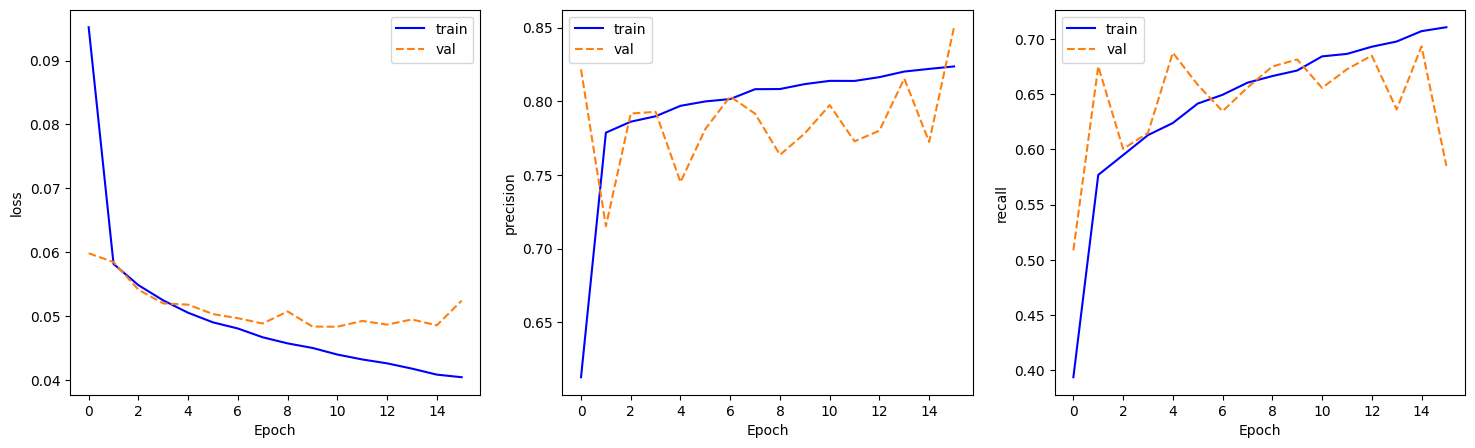

In [43]:
# Carrega o log de treinamento do modelo 10 no fold 0 (fold com melhor performance)
history = pd.read_csv('models/final_model/hist/train_log.csv')

# Plota as learning curvs do modelo
plot_history(history)

Verificamos que o modelo testado atingiu um resultado de 0,818 o que está próximo dos 0,828 que foram verificados nos conjuntos de validação durante a etapa de busca pelos melhores hiperparâmetros.

# Referências

Abaixo indico as referências que foram utilizadas durante o desenvolvimento deste projeto:

- https://medium.com/@zake7749/top-1-solution-to-toxic-comment-classification-challenge-ea28dbe75054
- https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=pt-br
- https://machinelearningmastery.com/what-is-imbalanced-classification/
- https://machinelearningmastery.com/deep-learning-for-nlp/